In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df1 = pd.read_csv('trips_2018_cleaned.csv',index_col=0)

# Task 1

In [ ]:
# Extract unique stations
coordinates_station = df1[['start_station_id','start_station_latitude','start_station_longitude']].dropna().drop_duplicates() 

# Apply K-Means clustering
kmeans = KMeans(n_clusters=20, random_state=67)
coordinates_station['clusters'] = kmeans.fit_predict(
    coordinates_station[['start_station_latitude', 'start_station_longitude']]
)

# CLEAN METHOD: Use dictionary mapping instead of merge
station_to_cluster = dict(zip(coordinates_station['start_station_id'], 
                               coordinates_station['clusters']))

# Add cluster columns directly (no merge = no duplicates!)
df1['start_cluster'] = df1['start_station_id'].map(station_to_cluster)
df1['end_cluster'] = df1['end_station_id'].map(station_to_cluster)

#Altenative method 

In [ ]:
coordinates_station = df1[['start_station_id','start_station_latitude','start_station_longitude']].dropna().drop_duplicates() 

kmeans = KMeans(n_clusters=20, random_state=67)
coordinates_station['clusters'] = kmeans.fit_predict(
    coordinates_station[['start_station_latitude', 'start_station_longitude']]
)

# Merge clusters back to main dataframe
df1 = df1.merge(
    coordinates_station[['start_station_id', 'clusters']],
    on='start_station_id',
    how='left'
).rename(columns={'clusters': 'start_cluster'})

df1 = df1.merge(  
    coordinates_station[['start_station_id', 'clusters']],
    left_on='end_station_id',
    right_on='start_station_id',
    how='left'
).rename(columns={'clusters': 'end_cluster'})



,starttime,stoptime,start_station_id_x,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,...,gender,calculated_duration,date,hour,day_of_week,month,week,start_cluster,start_station_id_y,end_cluster
0,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,...,1,970.752,2018-01-01,13,Monday,1,1,14,505.0,12.0
1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,...,1,723.159,2018-01-01,15,Monday,1,1,14,3255.0,12.0
2,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,...,1,496.835,2018-01-01,15,Monday,1,1,14,525.0,12.0
3,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,...,1,306.819,2018-01-01,15,Monday,1,1,14,447.0,14.0
4,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,...,1,306.074,2018-01-01,18,Monday,1,1,14,3356.0,14.0


In [8]:
df1 = df1.rename(columns={'start_station_id_x': 'start_station_id'})
df1 = df1.drop('start_station_id_y', axis=1)

df1.head()

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week,start_cluster,end_cluster
0,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,970.752,2018-01-01,13,Monday,1,1,14,12.0
1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,723.159,2018-01-01,15,Monday,1,1,14,12.0
2,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,496.835,2018-01-01,15,Monday,1,1,14,12.0
3,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,306.819,2018-01-01,15,Monday,1,1,14,14.0
4,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,306.074,2018-01-01,18,Monday,1,1,14,14.0


# Task 2

### Hourly demand function

In [ ]:
def create_hourly_demand(df, cluster_col, demand_type='pickups'):
    """
    Aggregate demand by cluster, date, and hour
    
    Parameters:
    - cluster_col: 'start_cluster' for pickups or 'end_cluster' for dropoffs
    - demand_type: 'pickups' or 'dropoffs' (for labeling)
    """
    hourly_demand = df.groupby([cluster_col, 'date', 'hour']).size().reset_index(name=demand_type)
    return hourly_demand

# Creating pickup and dropoff datasets
pickups_hourly = create_hourly_demand(df1, 'start_cluster', 'pickups')
dropoffs_hourly = create_hourly_demand(df1, 'end_cluster', 'dropoffs')


,start_cluster,date,hour,pickups
0,0,2018-01-01,0,12
1,0,2018-01-01,1,11
2,0,2018-01-01,2,4
3,0,2018-01-01,3,1
4,0,2018-01-01,4,2


### Choosing top clusters for analysis 

In [9]:
# Selecting top 3 clusters by total demand for analysis
cluster_demand = df1.groupby('start_cluster').size().sort_values(ascending=False)
selected_clusters = cluster_demand.head(3).index.tolist()

print(f"SELECTED CLUSTERS FOR PREDICTION: {selected_clusters}")


for cluster_id in selected_clusters:
    total_pickups = cluster_demand[cluster_id]
    num_stations = df1[df1['start_cluster'] == cluster_id]['start_station_id'].nunique()
    print(f"\nCluster {cluster_id}:")
    print(f"  - Total pickups: {total_pickups:,}")
    print(f"  - Number of stations: {num_stations}")

SELECTED CLUSTERS FOR PREDICTION: [12, 1, 4]

Cluster 12:
  - Total pickups: 3,147,103
  - Number of stations: 64

Cluster 1:
  - Total pickups: 2,619,819
  - Number of stations: 61

Cluster 4:
  - Total pickups: 2,307,157
  - Number of stations: 60


### Creating train and test sets

In [10]:
# Split data: January-October for training, November-December for testing
train_end_date = pd.to_datetime('2018-10-31')
test_start_date = pd.to_datetime('2018-11-01')

def train_test_split_timeseries(data, date_col='date'):
    """
    Training: Jan-Oct
    Testing: Nov-Dec
    """
    data[date_col] = pd.to_datetime(data[date_col])
    
    train = data[data[date_col] <= train_end_date].copy()
    test = data[data[date_col] >= test_start_date].copy()
    
    return train, test

# Split pickup and dropoff data
pickups_train, pickups_test = train_test_split_timeseries(pickups_hourly)
dropoffs_train, dropoffs_test = train_test_split_timeseries(dropoffs_hourly)

print(f"\nTraining period: {pickups_train['date'].min()} to {pickups_train['date'].max()}")
print(f"Testing period: {pickups_test['date'].min()} to {pickups_test['date'].max()}")
print(f"\nTraining samples: {len(pickups_train):,}")
print(f"Testing samples: {len(pickups_test):,}")


Training period: 2018-01-01 00:00:00 to 2018-10-31 00:00:00
Testing period: 2018-11-01 00:00:00 to 2018-12-31 00:00:00

Training samples: 136,726
Testing samples: 27,279


### Features

In [12]:
def create_features(data, cluster_col='start_cluster'):
    """
    Create features for time-series prediction
    
    Features include:
    - Hour of day
    - Day of week
    - Day of month
    - Month
    - Week of year
    - Is weekend
    - Lagged demand (previous hours/days)
    - Rolling averages
    """
    data = data.copy()
    data['date'] = pd.to_datetime(data['date'])
    
    # Time-based features
    data['day_of_week'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6
    data['day_of_month'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['week_of_year'] = data['date'].dt.isocalendar().week
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Sort by cluster, date, hour for lag features
    data = data.sort_values([cluster_col, 'date', 'hour'])
    
    # Determine demand column name
    demand_col = 'pickups' if 'pickups' in data.columns else 'dropoffs'
    
    # Lag features (previous hours)
    for lag in [1, 2, 3, 24, 48, 168]:  # 1h, 2h, 3h, 1day, 2days, 1week ago
        data[f'{demand_col}_lag_{lag}h'] = data.groupby(cluster_col)[demand_col].shift(lag)
    
    # Rolling averages
    for window in [3, 6, 12, 24]:
        data[f'{demand_col}_rolling_mean_{window}h'] = (
            data.groupby(cluster_col)[demand_col]
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
    
    # Fill NaN values from lag features
    data = data.fillna(method='bfill').fillna(0)
    
    return data

pickups_train_fe = create_features(pickups_train, 'start_cluster')
pickups_test_fe = create_features(pickups_test, 'start_cluster')


dropoffs_train_fe = create_features(dropoffs_train, 'end_cluster')
dropoffs_test_fe = create_features(dropoffs_test, 'end_cluster')



/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_65873/2875486849.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(0)
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_65873/2875486849.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(0)
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_65873/2875486849.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(0)
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_65873/2875486849.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

### Predeiction models

In [23]:
def create_features(data, cluster_col='start_cluster'):
    """
    Create features for time-series prediction WITHOUT data leakage
    
    Key principles:
    - Only use information available BEFORE the prediction time
    - Lag features must shift by at least 1
    - Rolling averages must exclude current value
    """
    data = data.copy()
    data['date'] = pd.to_datetime(data['date'])
    
    # Time-based features (SAFE - derived from date/time only)
    data['day_of_week'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6
    data['day_of_month'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['week_of_year'] = data['date'].dt.isocalendar().week
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Sort by cluster, date, hour for proper lag calculation
    data = data.sort_values([cluster_col, 'date', 'hour'])
    
    # Determine demand column name
    demand_col = 'pickups' if 'pickups' in data.columns else 'dropoffs'
    
    # ============================================================
    # LAG FEATURES - Look at PAST values only
    # ============================================================
    # shift(1) = 1 hour ago
    # shift(24) = 1 day ago (same hour yesterday)
    # shift(168) = 1 week ago (same hour last week)
    
    for lag in [1, 2, 3, 24, 48, 168]:
        data[f'{demand_col}_lag_{lag}h'] = data.groupby(cluster_col)[demand_col].shift(lag)
    
    # ============================================================
    # ROLLING AVERAGES - Must exclude current value!
    # ============================================================
    # CRITICAL: Use shift(1) BEFORE rolling to exclude current row
    
    for window in [3, 6, 12, 24]:
        # Calculate rolling mean of PAST values only
        data[f'{demand_col}_rolling_mean_{window}h'] = (
            data.groupby(cluster_col)[demand_col]
            .shift(1)  # ← CRITICAL: Shift first to exclude current value
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        # Calculate rolling std of PAST values only
        data[f'{demand_col}_rolling_std_{window}h'] = (
            data.groupby(cluster_col)[demand_col]
            .shift(1)  # ← CRITICAL: Shift first to exclude current value
            .rolling(window=window, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )
    
    # Fill NaN values (only at the beginning due to lags)
    # Use forward fill first, then fill remaining with 0
    data = data.fillna(method='ffill').fillna(0)
    
    return data

print("✓ Feature engineering function updated with leakage prevention")

✓ Feature engineering function updated with leakage prevention


In [24]:
def build_models_for_cluster(train_data, test_data, cluster_id, cluster_col, demand_col):
    """
    Build and compare multiple models for a specific cluster - NO LEAKAGE VERSION
    """
    # Filter data for this cluster
    train_cluster = train_data[train_data[cluster_col] == cluster_id].copy()
    test_cluster = test_data[test_data[cluster_col] == cluster_id].copy()
    
    # ============================================================
    # CRITICAL: Define feature columns - EXCLUDE target variable!
    # ============================================================
    exclude_cols = [
        cluster_col,     # Cluster ID (not a feature)
        'date',          # Date (already extracted time features from it)
        demand_col,      # TARGET VARIABLE - MUST EXCLUDE!
        'pickups',       # Exclude both pickups and dropoffs from features
        'dropoffs'       # to prevent any leakage
    ]
    
    # Get feature columns
    feature_cols = [col for col in train_cluster.columns if col not in exclude_cols]
    
    # ============================================================
    # VERIFICATION: Check for leakage
    # ============================================================
    print(f"\n🔍 Cluster {cluster_id} - {demand_col}")
    print(f"   Using {len(feature_cols)} features")
    
    # Verify target is not in features
    if demand_col in feature_cols:
        print(f"   ⚠️ ERROR: Target '{demand_col}' found in features!")
        feature_cols.remove(demand_col)
    
    # Verify other demand column is not in features
    other_demand = 'dropoffs' if demand_col == 'pickups' else 'pickups'
    if other_demand in feature_cols:
        print(f"   ⚠️ ERROR: '{other_demand}' found in features!")
        feature_cols.remove(other_demand)
    
    # Prepare X and y
    X_train = train_cluster[feature_cols]
    y_train = train_cluster[demand_col]
    X_test = test_cluster[feature_cols]
    y_test = test_cluster[demand_col]
    
    # ============================================================
    # Check for perfect correlation (data leakage indicator)
    # ============================================================
    for col in feature_cols:
        try:
            corr = np.corrcoef(X_train[col].fillna(0), y_train)[0, 1]
            if abs(corr) > 0.99:
                print(f"   ⚠️ WARNING: Feature '{col}' has suspiciously high correlation: {corr:.4f}")
        except:
            pass
    
    # ============================================================
    # Define models
    # ============================================================
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=15, 
            random_state=42, 
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1, 
            random_state=42
        )
    }
    
    # ============================================================
    # Train and evaluate each model
    # ============================================================
    results = {}
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred = np.maximum(y_pred, 0)  # Ensure non-negative predictions
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        test_with_pred = test_cluster.copy()
        test_with_pred['predicted'] = y_pred
        test_with_pred['actual'] = y_test
        
        results[model_name] = {
            'model': model,
            'predictions': test_with_pred,
            'metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        }
        
        print(f"   {model_name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    return results

print("✓ Model training function updated with leakage checks")

✓ Model training function updated with leakage checks


In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def build_models_for_cluster(train_data, test_data, cluster_id, cluster_col, demand_col):
    """
    Build and compare multiple models for a specific cluster
    """
    # Filter data for this cluster
    train_cluster = train_data[train_data[cluster_col] == cluster_id].copy()
    test_cluster = test_data[test_data[cluster_col] == cluster_id].copy()
    
    # Define feature columns
    exclude_cols = [cluster_col, 'date', demand_col]
    feature_cols = [col for col in train_cluster.columns if col not in exclude_cols]
    
    # Prepare X and y
    X_train = train_cluster[feature_cols]
    y_train = train_cluster[demand_col]
    X_test = test_cluster[feature_cols]
    y_test = test_cluster[demand_col]
    
    # Define models to compare
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=67, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=67)
    }
    
    # Train and evaluate each model
    results = {}
    
    for model_name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_pred = np.maximum(y_pred, 0)  # Ensure non-negative
        
        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        test_with_pred = test_cluster.copy()
        test_with_pred['predicted'] = y_pred
        test_with_pred['actual'] = y_test
        
        results[model_name] = {
            'model': model,
            'predictions': test_with_pred,
            'metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        }
        
        print(f"  {model_name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    
    return results

# Train all models for each cluster
print("\n" + "="*80)
print("TRAINING AND COMPARING MODELS")
print("="*80)

all_pickup_results = {}
all_dropoff_results = {}

for cluster_id in selected_clusters:
    print(f"\n--- Cluster {cluster_id} - PICKUPS ---")
    all_pickup_results[cluster_id] = build_models_for_cluster(
        pickups_train_fe, pickups_test_fe, 
        cluster_id, 'start_cluster', 'pickups'
    )
    
    print(f"\n--- Cluster {cluster_id} - DROPOFFS ---")
    all_dropoff_results[cluster_id] = build_models_for_cluster(
        dropoffs_train_fe, dropoffs_test_fe,
        cluster_id, 'end_cluster', 'dropoffs'
    )


TRAINING AND COMPARING MODELS

--- Cluster 12 - PICKUPS ---
  Random Forest: MAE=22.09, RMSE=40.72, R²=0.977
  Gradient Boosting: MAE=20.75, RMSE=34.10, R²=0.984

--- Cluster 12 - DROPOFFS ---
  Random Forest: MAE=20.82, RMSE=43.65, R²=0.976
  Gradient Boosting: MAE=19.76, RMSE=34.20, R²=0.986

--- Cluster 1 - PICKUPS ---
  Random Forest: MAE=16.94, RMSE=32.31, R²=0.977
  Gradient Boosting: MAE=15.88, RMSE=25.54, R²=0.986

--- Cluster 1 - DROPOFFS ---
  Random Forest: MAE=17.49, RMSE=31.22, R²=0.979
  Gradient Boosting: MAE=17.16, RMSE=27.57, R²=0.983

--- Cluster 4 - PICKUPS ---
  Random Forest: MAE=18.68, RMSE=45.63, R²=0.965
  Gradient Boosting: MAE=18.35, RMSE=33.09, R²=0.982

--- Cluster 4 - DROPOFFS ---
  Random Forest: MAE=14.31, RMSE=26.47, R²=0.990
  Gradient Boosting: MAE=16.88, RMSE=28.31, R²=0.988



VISUALIZING 24-HOUR AHEAD PREDICTIONS

Cluster 12 - Pickups:


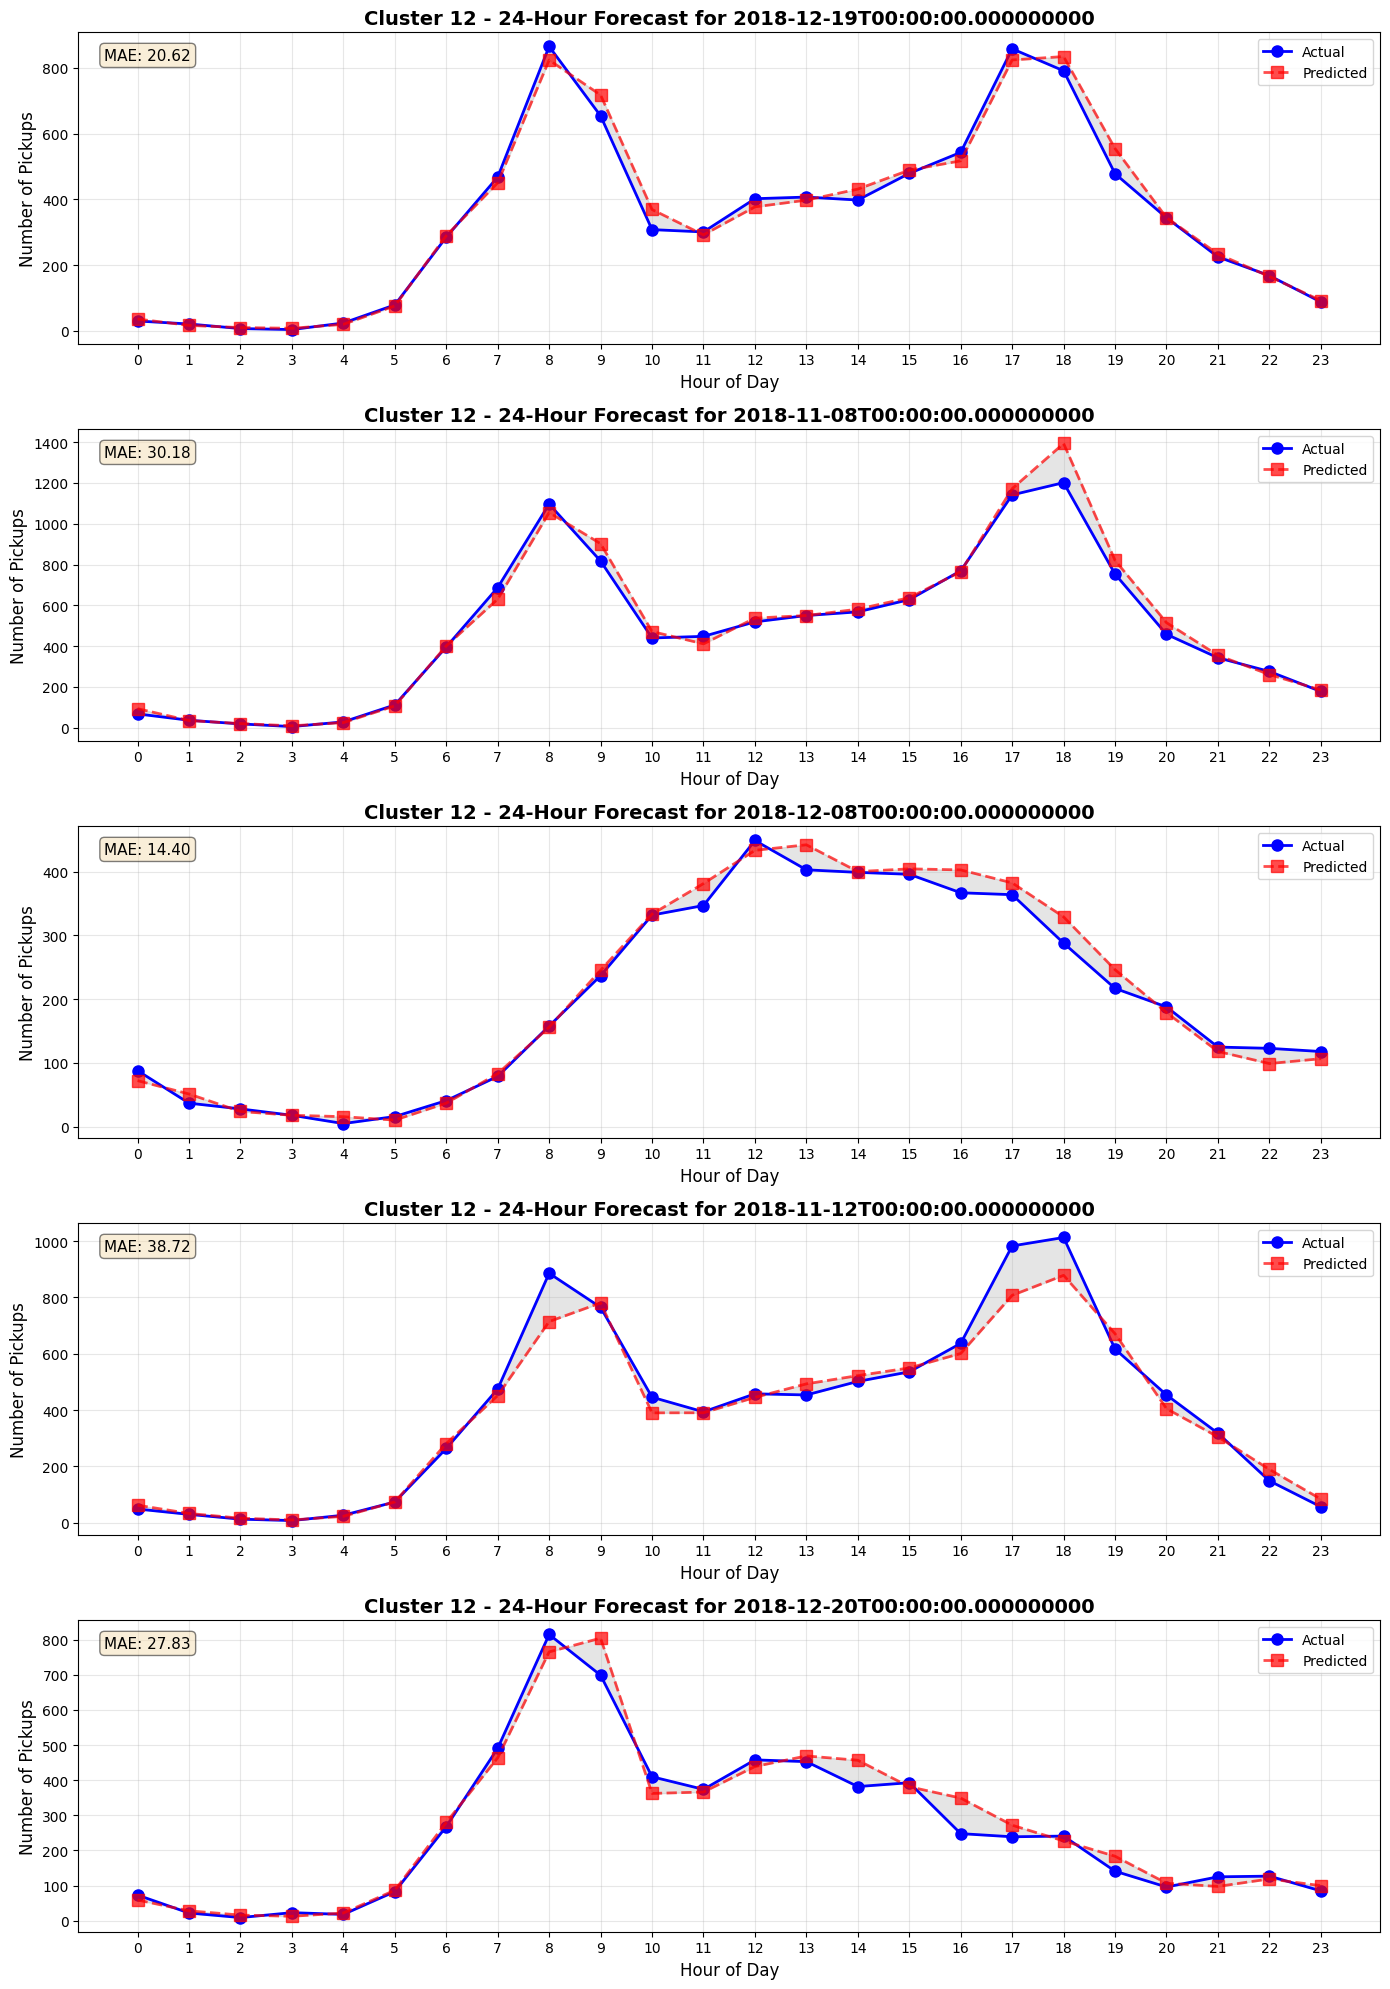


Cluster 12 - Dropoffs:


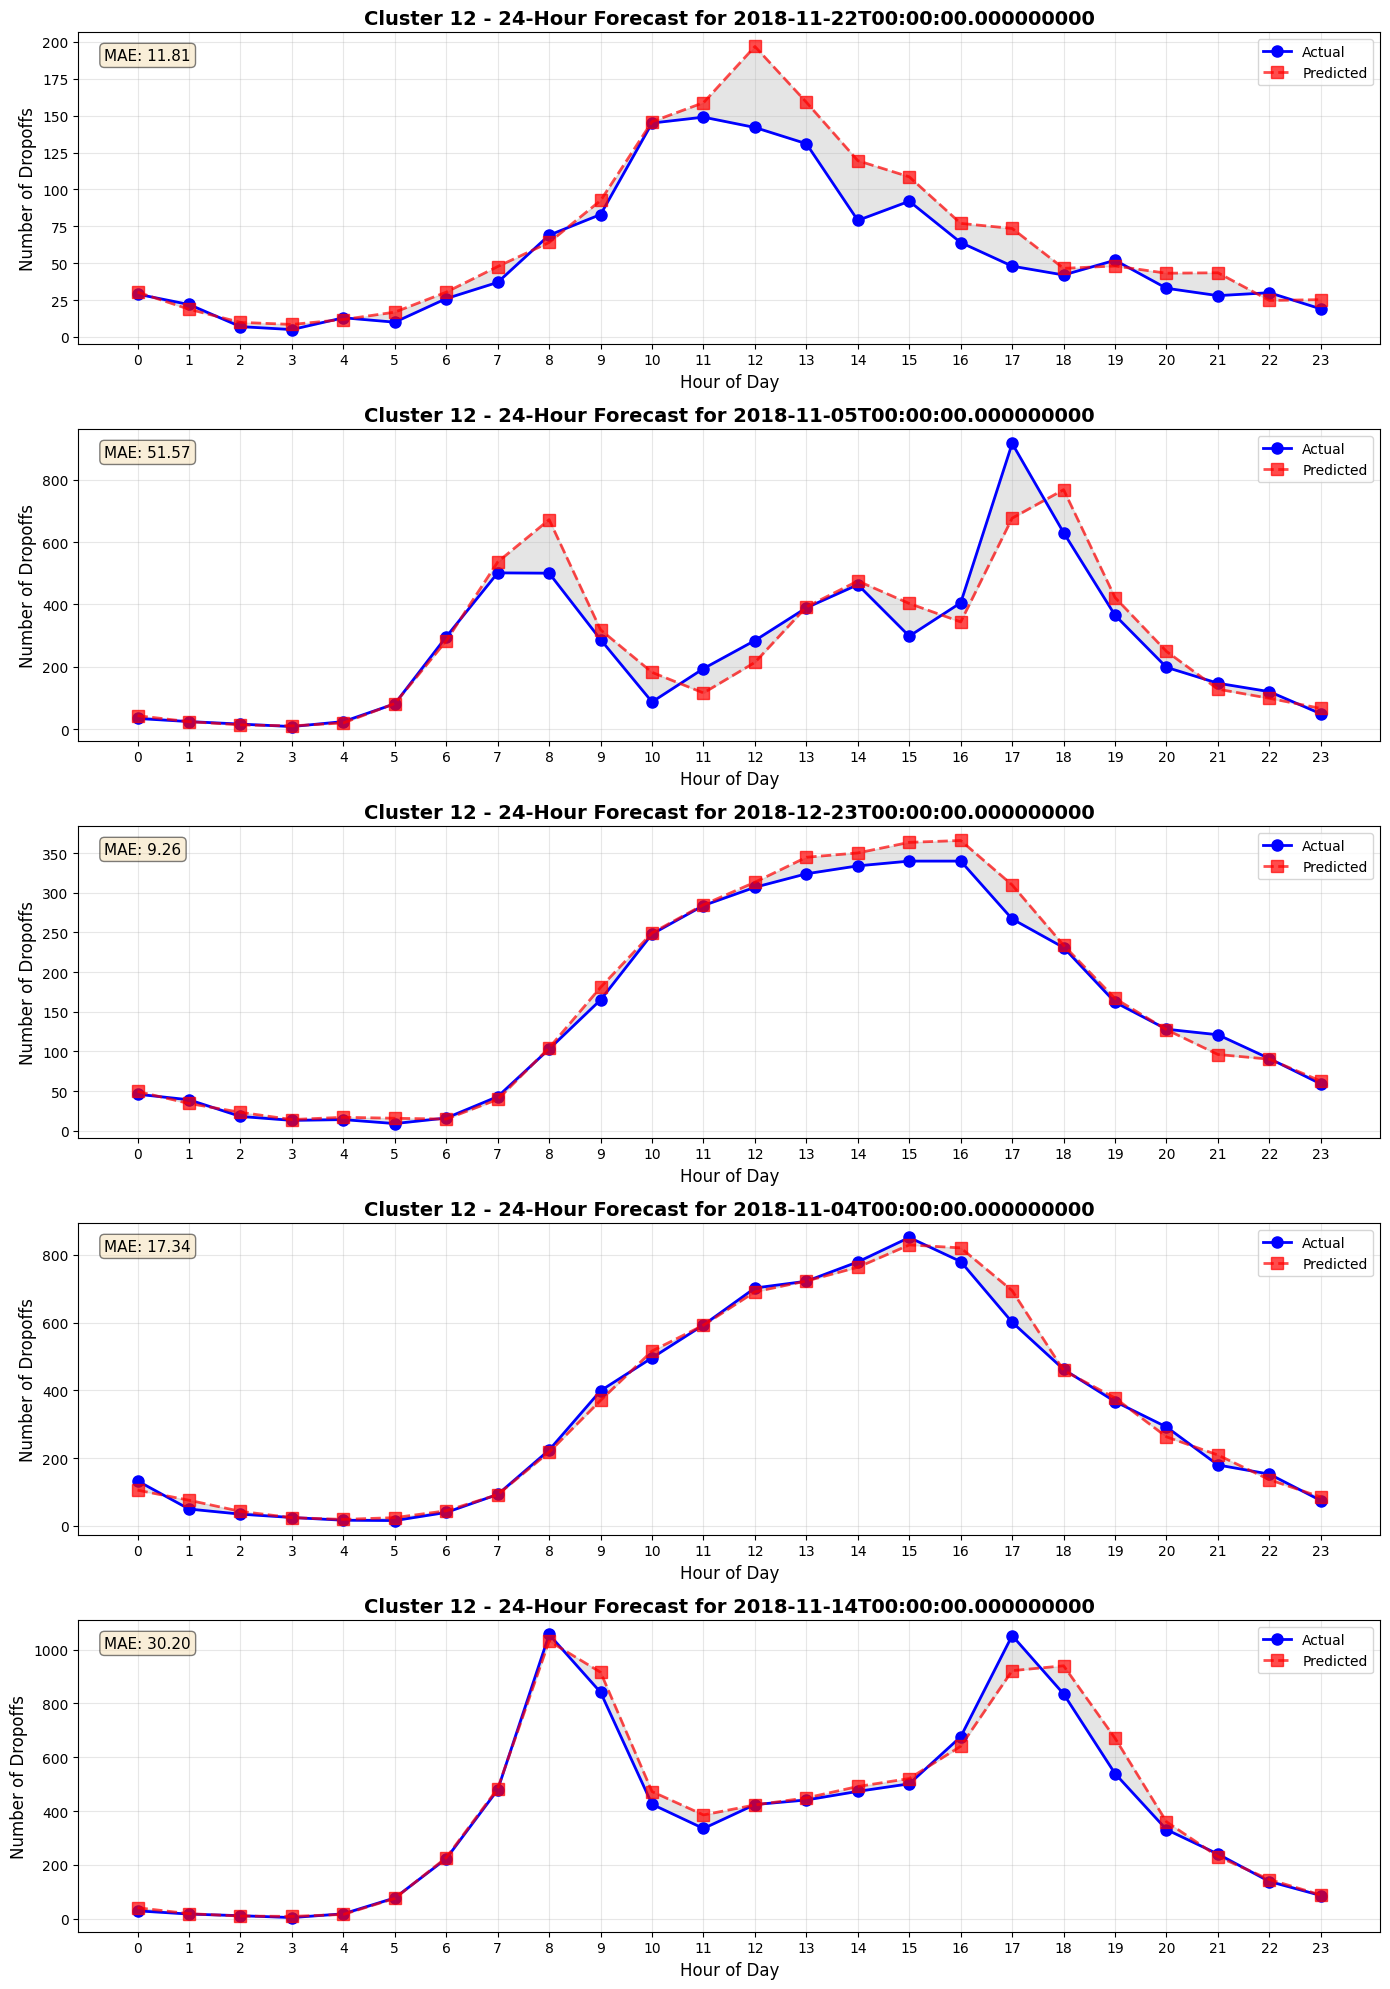


Cluster 1 - Pickups:


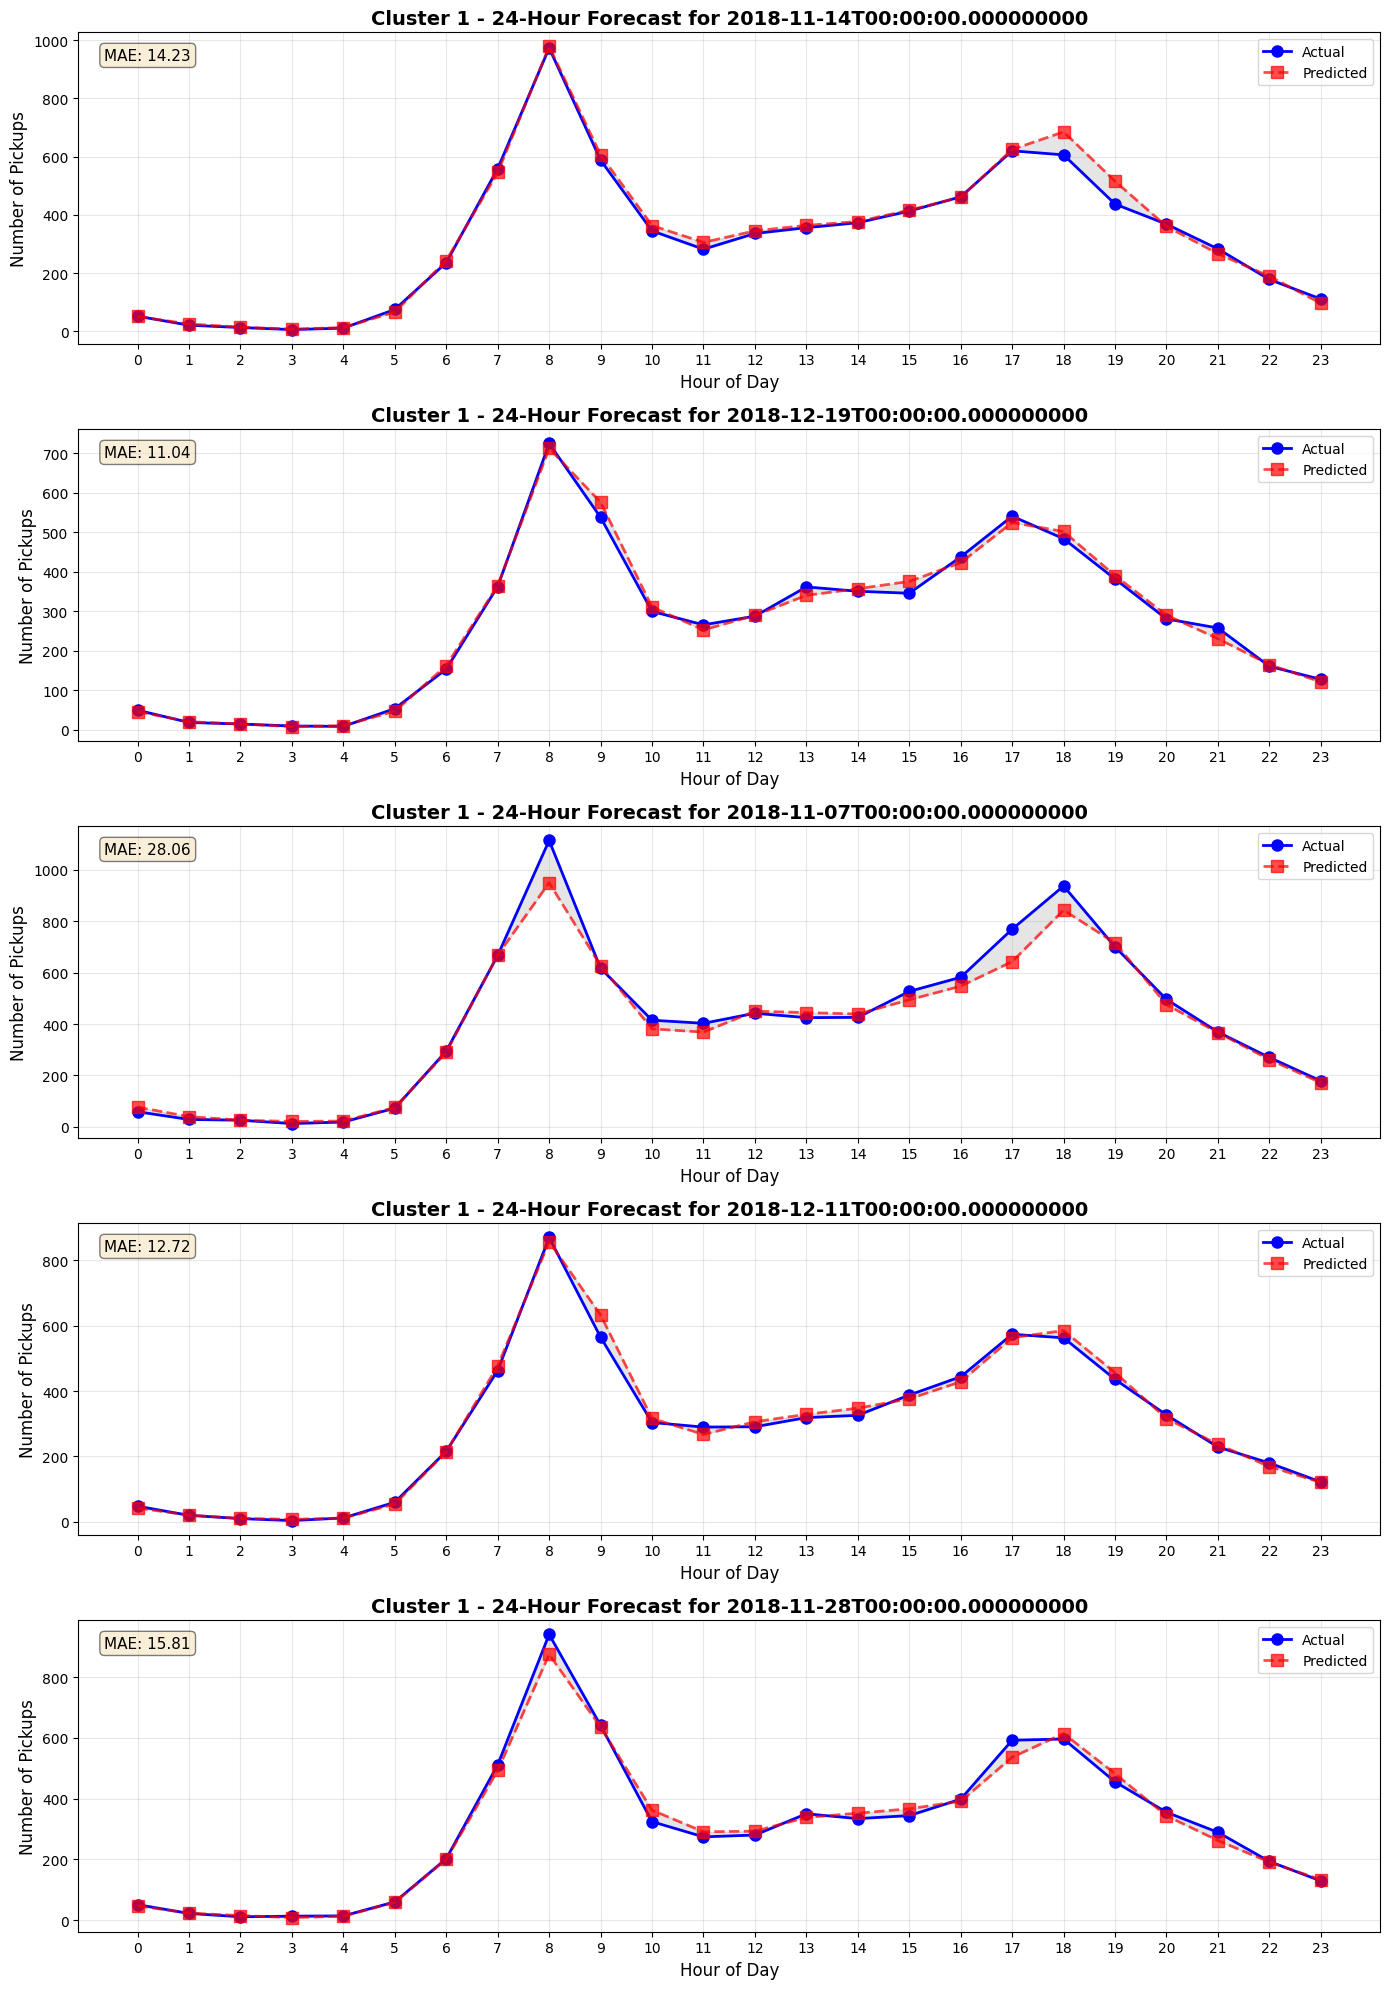


Cluster 1 - Dropoffs:


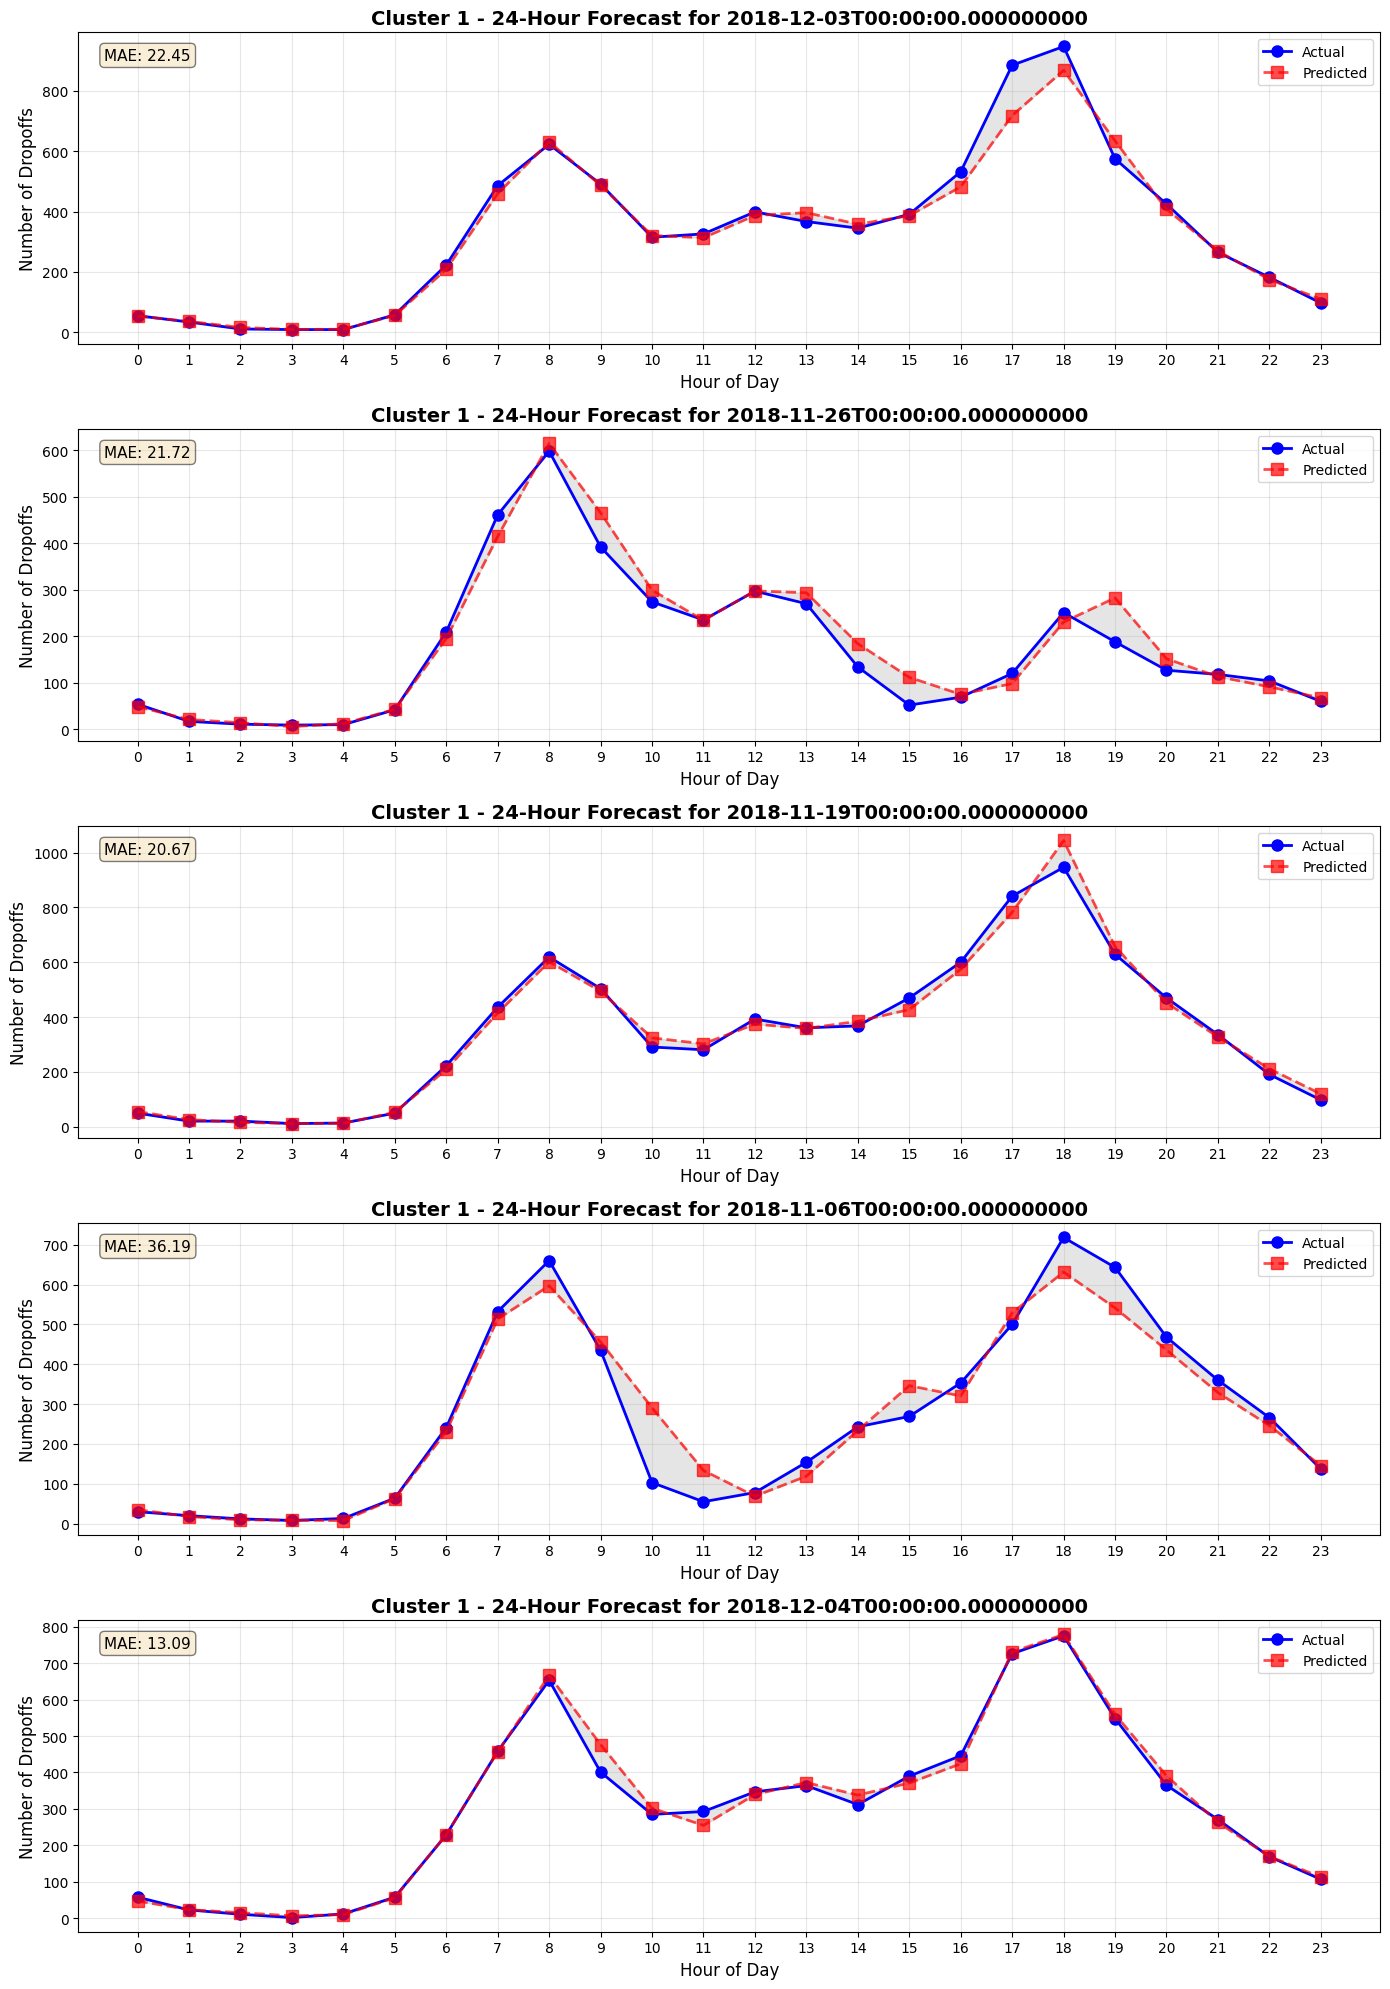


Cluster 4 - Pickups:


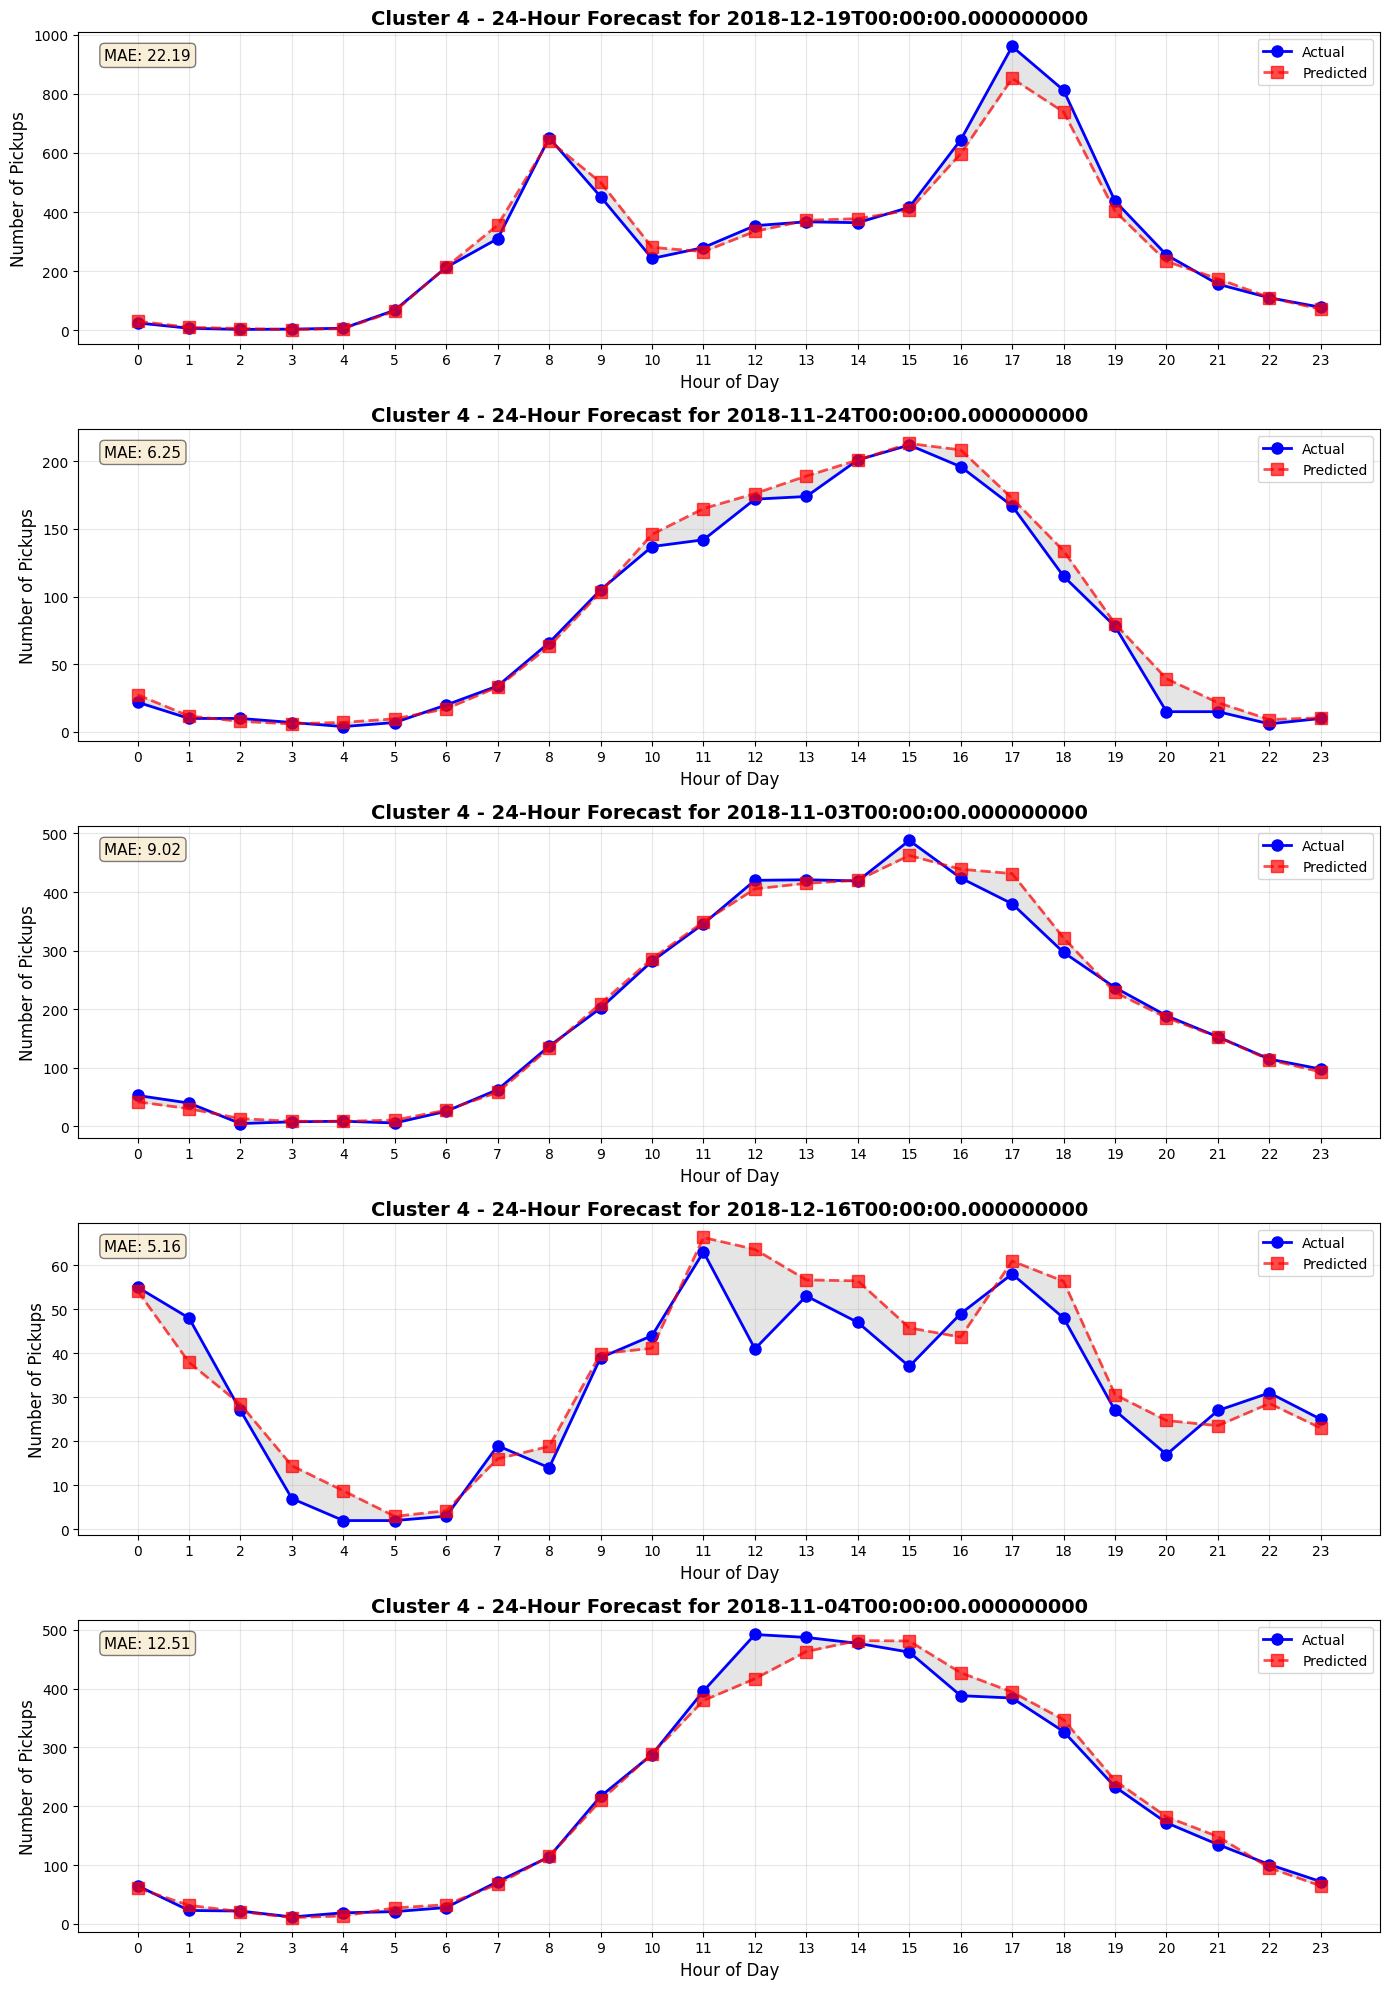


Cluster 4 - Dropoffs:


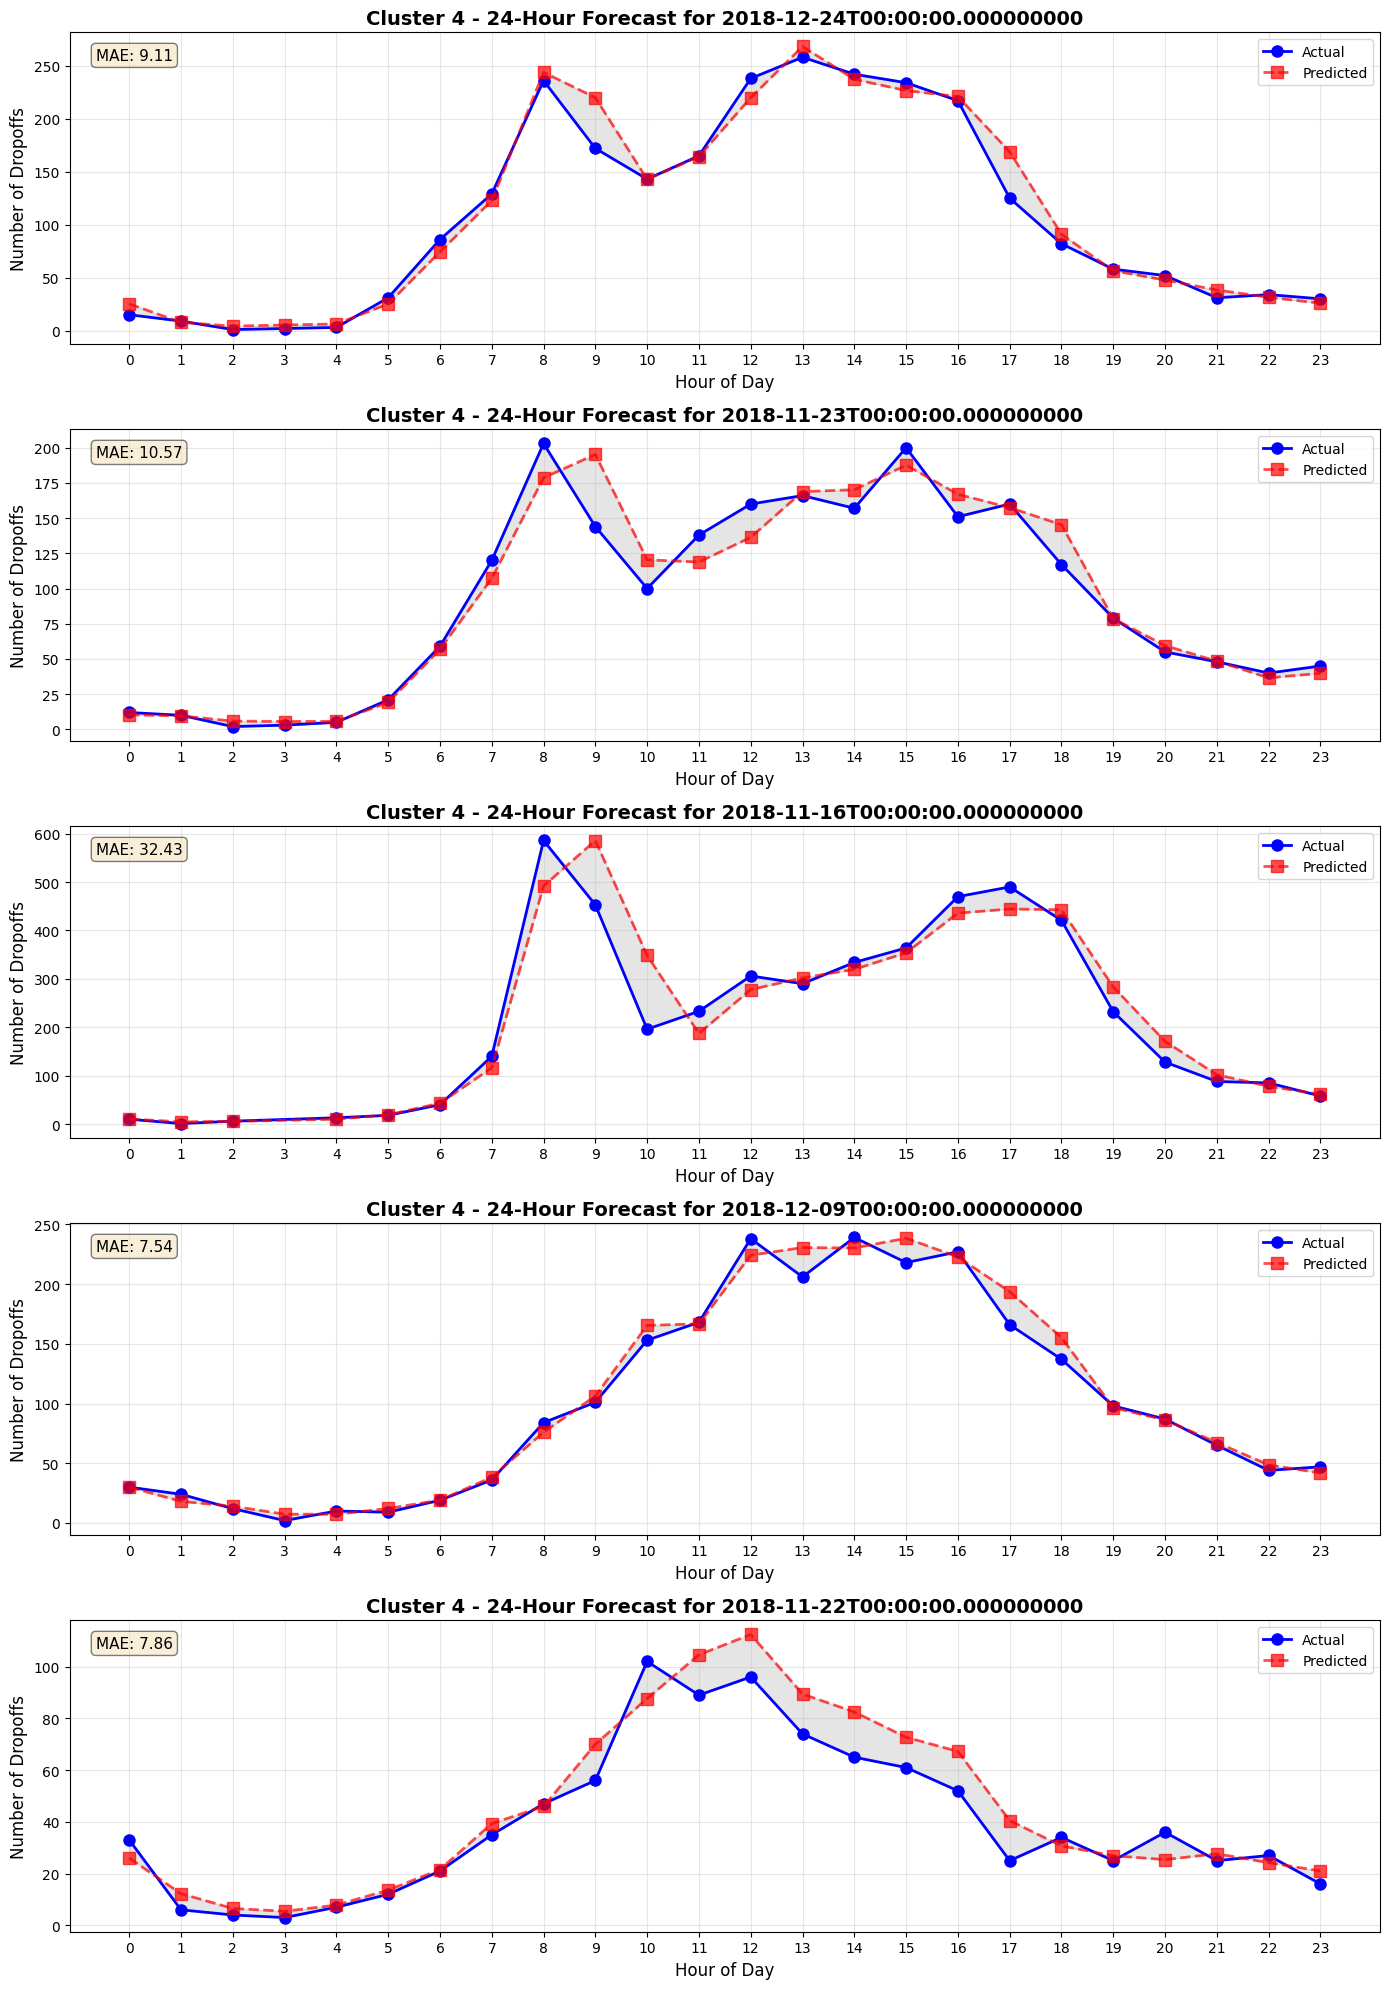

In [14]:
def visualize_next_day_predictions(predictions_data, cluster_id, demand_type='pickups'):
    """
    Visualize 24-hour ahead predictions (simulating end-of-day prediction)
    
    Shows how well the model predicts the next day's hourly pattern
    """
    # Select a few example days from the test set
    test_dates = predictions_data['date'].unique()
    sample_dates = np.random.choice(test_dates, size=min(5, len(test_dates)), replace=False)
    
    fig, axes = plt.subplots(len(sample_dates), 1, figsize=(14, 4*len(sample_dates)))
    if len(sample_dates) == 1:
        axes = [axes]
    
    for idx, date in enumerate(sample_dates):
        day_data = predictions_data[predictions_data['date'] == date].sort_values('hour')
        
        axes[idx].plot(day_data['hour'], day_data['actual'], 
                      marker='o', linewidth=2, label='Actual', color='blue', markersize=8)
        axes[idx].plot(day_data['hour'], day_data['predicted'], 
                      marker='s', linewidth=2, label='Predicted', color='red', 
                      linestyle='--', markersize=8, alpha=0.7)
        
        axes[idx].fill_between(day_data['hour'], day_data['actual'], day_data['predicted'], 
                              alpha=0.2, color='gray')
        
        axes[idx].set_xlabel('Hour of Day', fontsize=12)
        axes[idx].set_ylabel(f'Number of {demand_type.capitalize()}', fontsize=12)
        axes[idx].set_title(f'Cluster {cluster_id} - 24-Hour Forecast for {date}', 
                           fontweight='bold', fontsize=14)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xticks(range(0, 24))
        
        # Add MAE for this day
        day_mae = mean_absolute_error(day_data['actual'], day_data['predicted'])
        axes[idx].text(0.02, 0.95, f'MAE: {day_mae:.2f}', 
                      transform=axes[idx].transAxes, fontsize=11,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Visualize predictions for each selected cluster
print("\n" + "="*80)
print("VISUALIZING 24-HOUR AHEAD PREDICTIONS")
print("="*80)

for cluster_id in selected_clusters:
    print(f"\nCluster {cluster_id} - Pickups:")
    visualize_next_day_predictions(
        pickup_models[cluster_id]['predictions'], 
        cluster_id, 
        'pickups'
    )
    
    print(f"\nCluster {cluster_id} - Dropoffs:")
    visualize_next_day_predictions(
        dropoff_models[cluster_id]['predictions'], 
        cluster_id, 
        'dropoffs'
    )


MODEL PERFORMANCE COMPARISON ACROSS CLUSTERS
 Cluster  Pickups MAE  Pickups RMSE  Pickups R²  Dropoffs MAE  Dropoffs RMSE  Dropoffs R²
      12        22.89         42.90       0.974         20.64          43.15        0.977
       1        16.98         32.86       0.976         17.59          31.53        0.978
       4        18.91         45.55       0.965         14.33          26.41        0.990


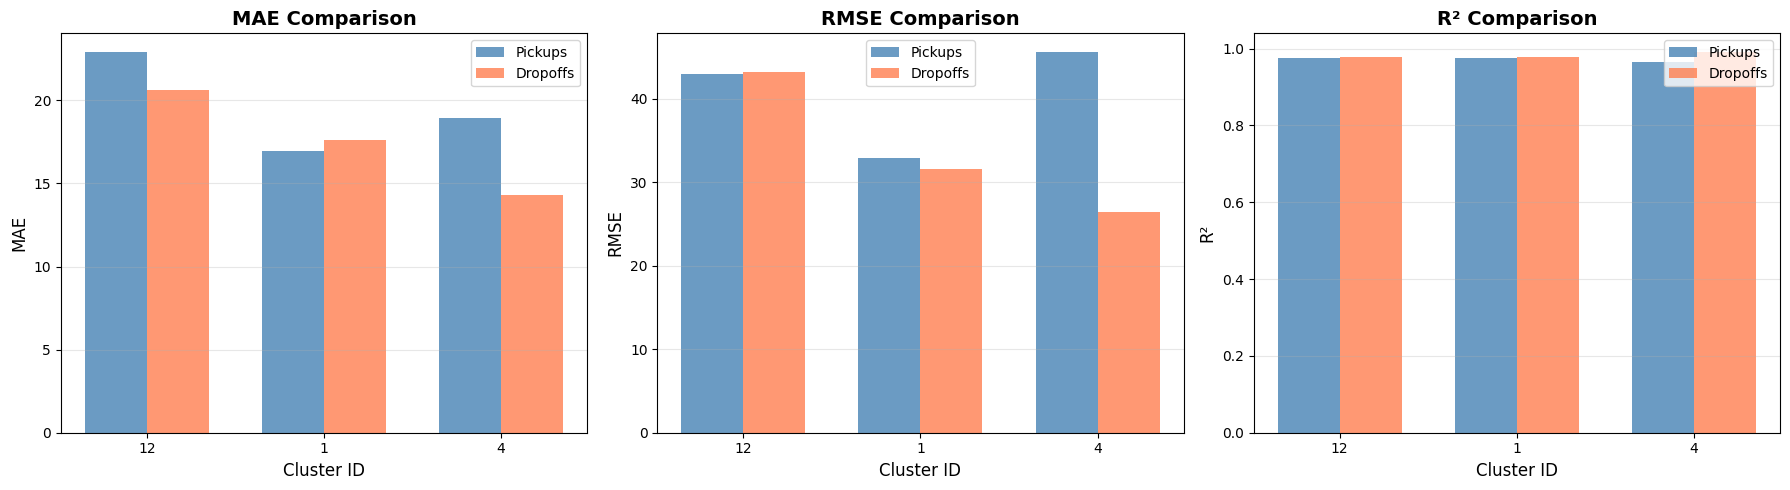

In [15]:
# Create comparison table
comparison_data = []

for cluster_id in selected_clusters:
    pickup_metrics = pickup_models[cluster_id]['metrics']
    dropoff_metrics = dropoff_models[cluster_id]['metrics']
    
    comparison_data.append({
        'Cluster': cluster_id,
        'Pickups MAE': round(pickup_metrics['MAE'], 2),
        'Pickups RMSE': round(pickup_metrics['RMSE'], 2),
        'Pickups R²': round(pickup_metrics['R2'], 3),
        'Dropoffs MAE': round(dropoff_metrics['MAE'], 2),
        'Dropoffs RMSE': round(dropoff_metrics['RMSE'], 2),
        'Dropoffs R²': round(dropoff_metrics['R2'], 3)
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON ACROSS CLUSTERS")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['MAE', 'RMSE', 'R²']
colors = ['steelblue', 'coral']

for idx, metric in enumerate(['MAE', 'RMSE', 'R²']):
    pickup_col = f'Pickups {metric}'
    dropoff_col = f'Dropoffs {metric}'
    
    x = np.arange(len(selected_clusters))
    width = 0.35
    
    axes[idx].bar(x - width/2, comparison_df[pickup_col], width, 
                  label='Pickups', color=colors[0], alpha=0.8)
    axes[idx].bar(x + width/2, comparison_df[dropoff_col], width, 
                  label='Dropoffs', color=colors[1], alpha=0.8)
    
    axes[idx].set_xlabel('Cluster ID', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontweight='bold', fontsize=14)
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(selected_clusters)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



FEATURE IMPORTANCE - CLUSTER 12

Top 10 Features for Pickups Prediction:
                 feature  importance
 pickups_rolling_mean_3h    0.435807
          pickups_lag_1h    0.301725
        pickups_lag_168h    0.141797
         pickups_lag_24h    0.036759
          pickups_lag_2h    0.022432
                    hour    0.019643
          pickups_lag_3h    0.018262
pickups_rolling_mean_12h    0.011835
 pickups_rolling_mean_6h    0.002446
             day_of_week    0.002113

Top 10 Features for Dropoffs Prediction:
                  feature  importance
 dropoffs_rolling_mean_3h    0.753615
        dropoffs_lag_168h    0.124121
         dropoffs_lag_24h    0.033140
                     hour    0.030821
          dropoffs_lag_3h    0.018592
          dropoffs_lag_2h    0.018174
          dropoffs_lag_1h    0.006606
 dropoffs_rolling_mean_6h    0.003384
dropoffs_rolling_mean_12h    0.003179
              day_of_week    0.002183


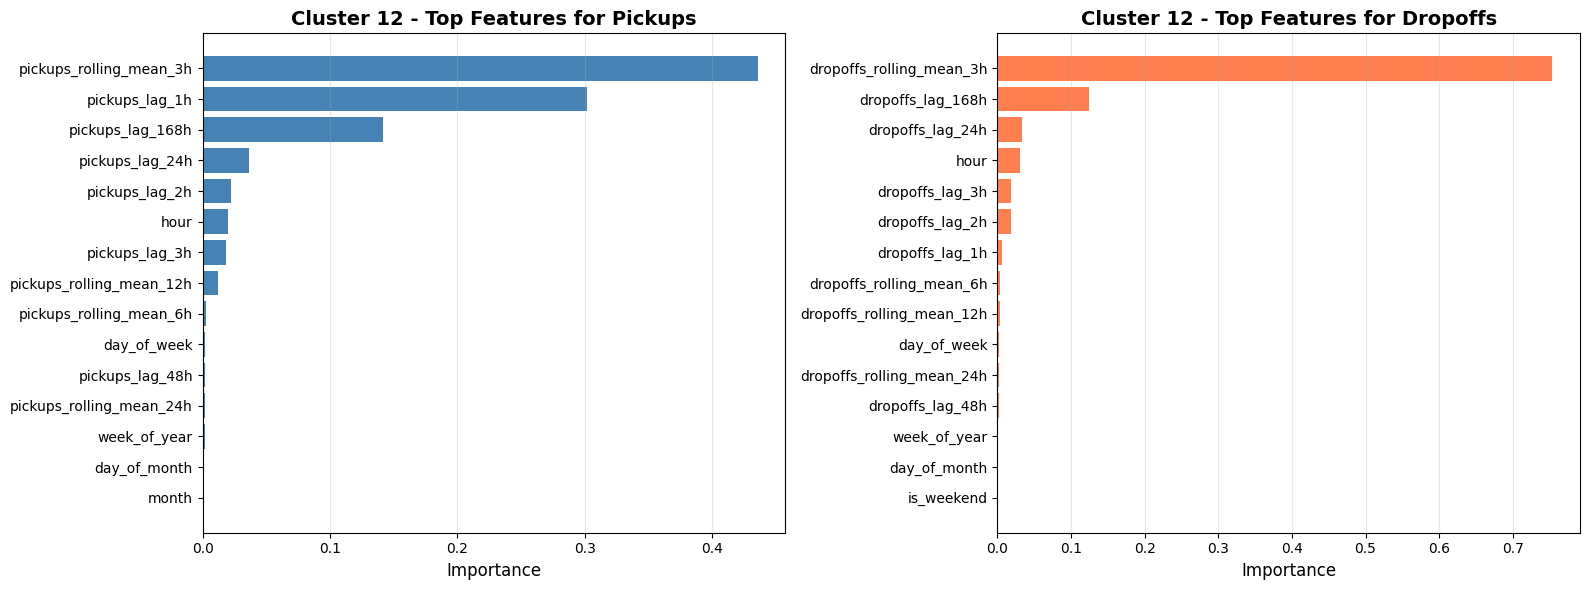


FEATURE IMPORTANCE - CLUSTER 1

Top 10 Features for Pickups Prediction:
                 feature  importance
 pickups_rolling_mean_3h    0.713916
        pickups_lag_168h    0.165380
         pickups_lag_24h    0.036047
          pickups_lag_3h    0.024805
          pickups_lag_2h    0.021240
                    hour    0.017125
          pickups_lag_1h    0.005530
pickups_rolling_mean_12h    0.004298
 pickups_rolling_mean_6h    0.003229
pickups_rolling_mean_24h    0.001937

Top 10 Features for Dropoffs Prediction:
                  feature  importance
 dropoffs_rolling_mean_3h    0.777325
        dropoffs_lag_168h    0.103738
          dropoffs_lag_2h    0.029442
          dropoffs_lag_3h    0.025003
         dropoffs_lag_24h    0.020412
                     hour    0.019116
          dropoffs_lag_1h    0.008345
dropoffs_rolling_mean_12h    0.006427
 dropoffs_rolling_mean_6h    0.002322
              day_of_week    0.001770


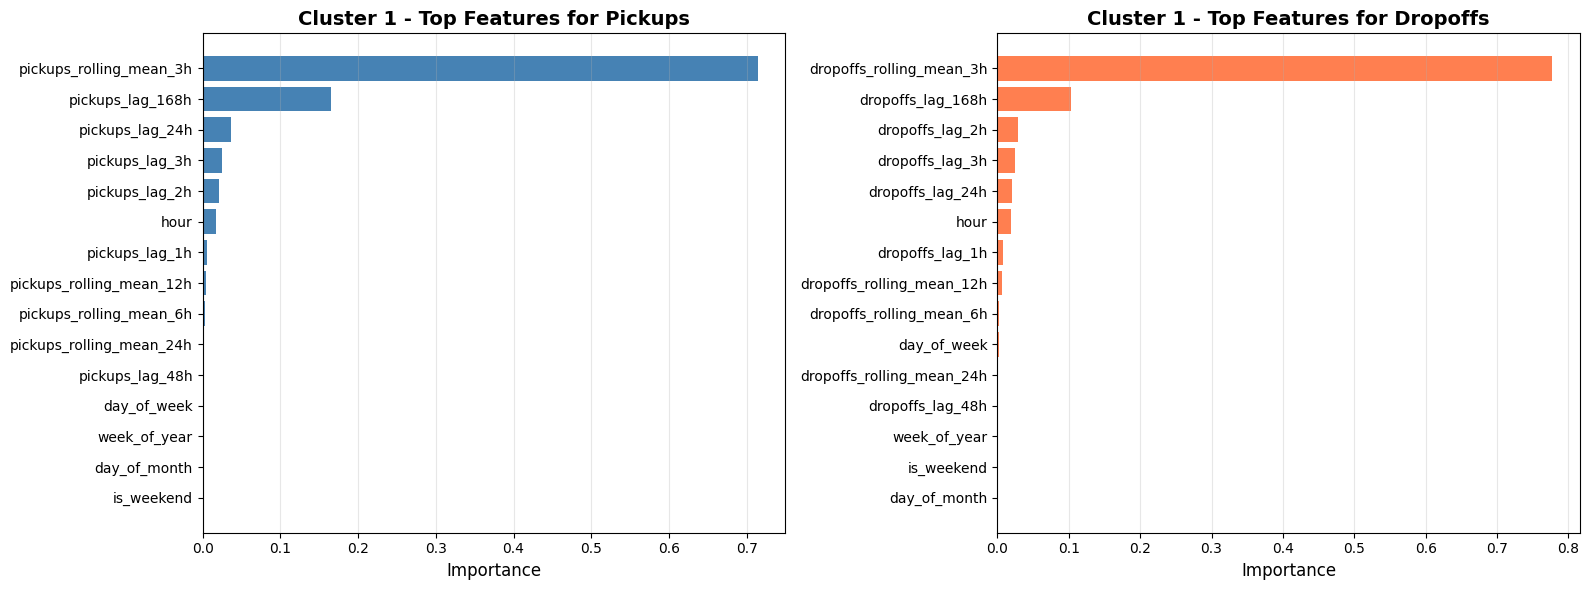


FEATURE IMPORTANCE - CLUSTER 4

Top 10 Features for Pickups Prediction:
                 feature  importance
 pickups_rolling_mean_3h    0.709820
        pickups_lag_168h    0.130051
                    hour    0.046515
          pickups_lag_2h    0.040143
         pickups_lag_24h    0.027463
          pickups_lag_1h    0.013093
          pickups_lag_3h    0.007067
pickups_rolling_mean_12h    0.006911
             day_of_week    0.004982
 pickups_rolling_mean_6h    0.004860

Top 10 Features for Dropoffs Prediction:
                  feature  importance
 dropoffs_rolling_mean_3h    0.646213
                     hour    0.224059
         dropoffs_lag_24h    0.033946
dropoffs_rolling_mean_12h    0.022743
 dropoffs_rolling_mean_6h    0.020521
        dropoffs_lag_168h    0.014141
          dropoffs_lag_2h    0.013932
          dropoffs_lag_1h    0.010444
          dropoffs_lag_3h    0.008087
dropoffs_rolling_mean_24h    0.001872


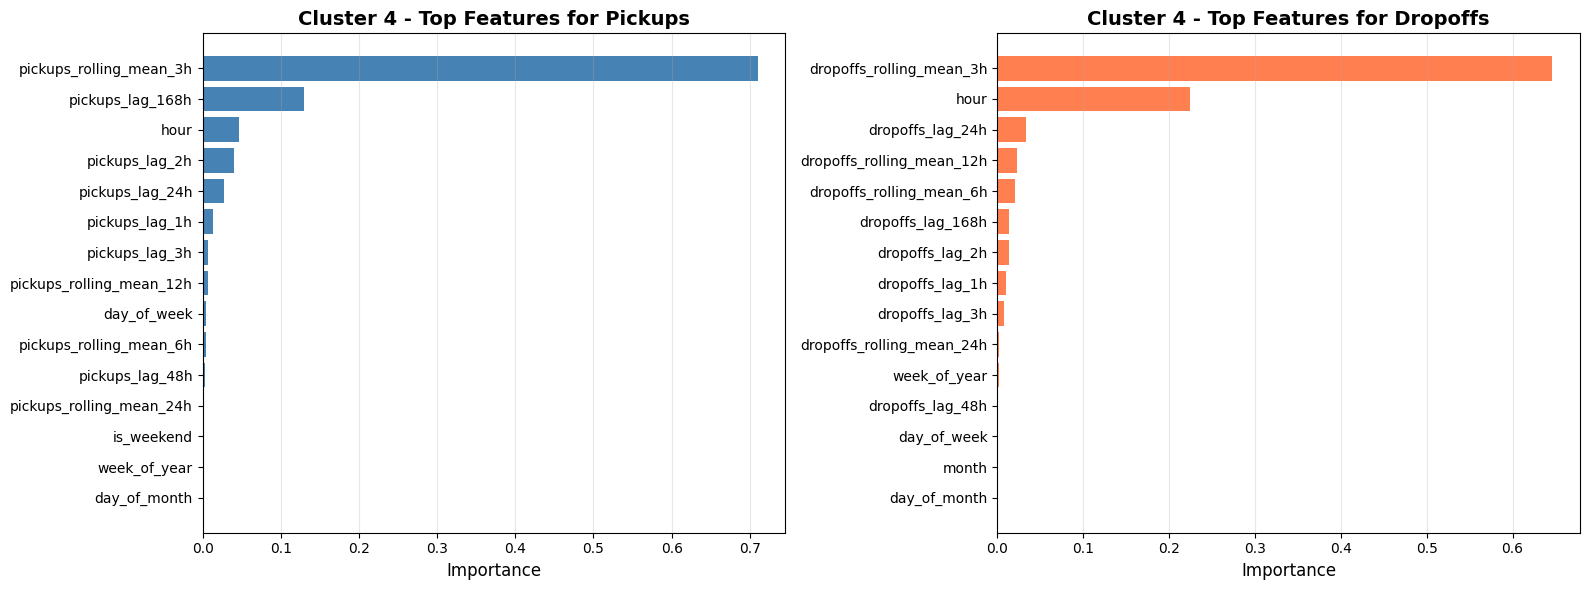

In [16]:
# Show which features are most important for prediction
for cluster_id in selected_clusters:
    print(f"\n{'='*80}")
    print(f"FEATURE IMPORTANCE - CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    print("\nTop 10 Features for Pickups Prediction:")
    print(pickup_models[cluster_id]['feature_importance'].head(10).to_string(index=False))
    
    print("\nTop 10 Features for Dropoffs Prediction:")
    print(dropoff_models[cluster_id]['feature_importance'].head(10).to_string(index=False))
    
    # Visualize top features
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pickups
    top_features_pickup = pickup_models[cluster_id]['feature_importance'].head(15)
    axes[0].barh(range(len(top_features_pickup)), top_features_pickup['importance'], color='steelblue')
    axes[0].set_yticks(range(len(top_features_pickup)))
    axes[0].set_yticklabels(top_features_pickup['feature'], fontsize=10)
    axes[0].set_xlabel('Importance', fontsize=12)
    axes[0].set_title(f'Cluster {cluster_id} - Top Features for Pickups', fontweight='bold', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Dropoffs
    top_features_dropoff = dropoff_models[cluster_id]['feature_importance'].head(15)
    axes[1].barh(range(len(top_features_dropoff)), top_features_dropoff['importance'], color='coral')
    axes[1].set_yticks(range(len(top_features_dropoff)))
    axes[1].set_yticklabels(top_features_dropoff['feature'], fontsize=10)
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title(f'Cluster {cluster_id} - Top Features for Dropoffs', fontweight='bold', fontsize=14)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


ERROR ANALYSIS

--- Cluster 12 - Pickups ---


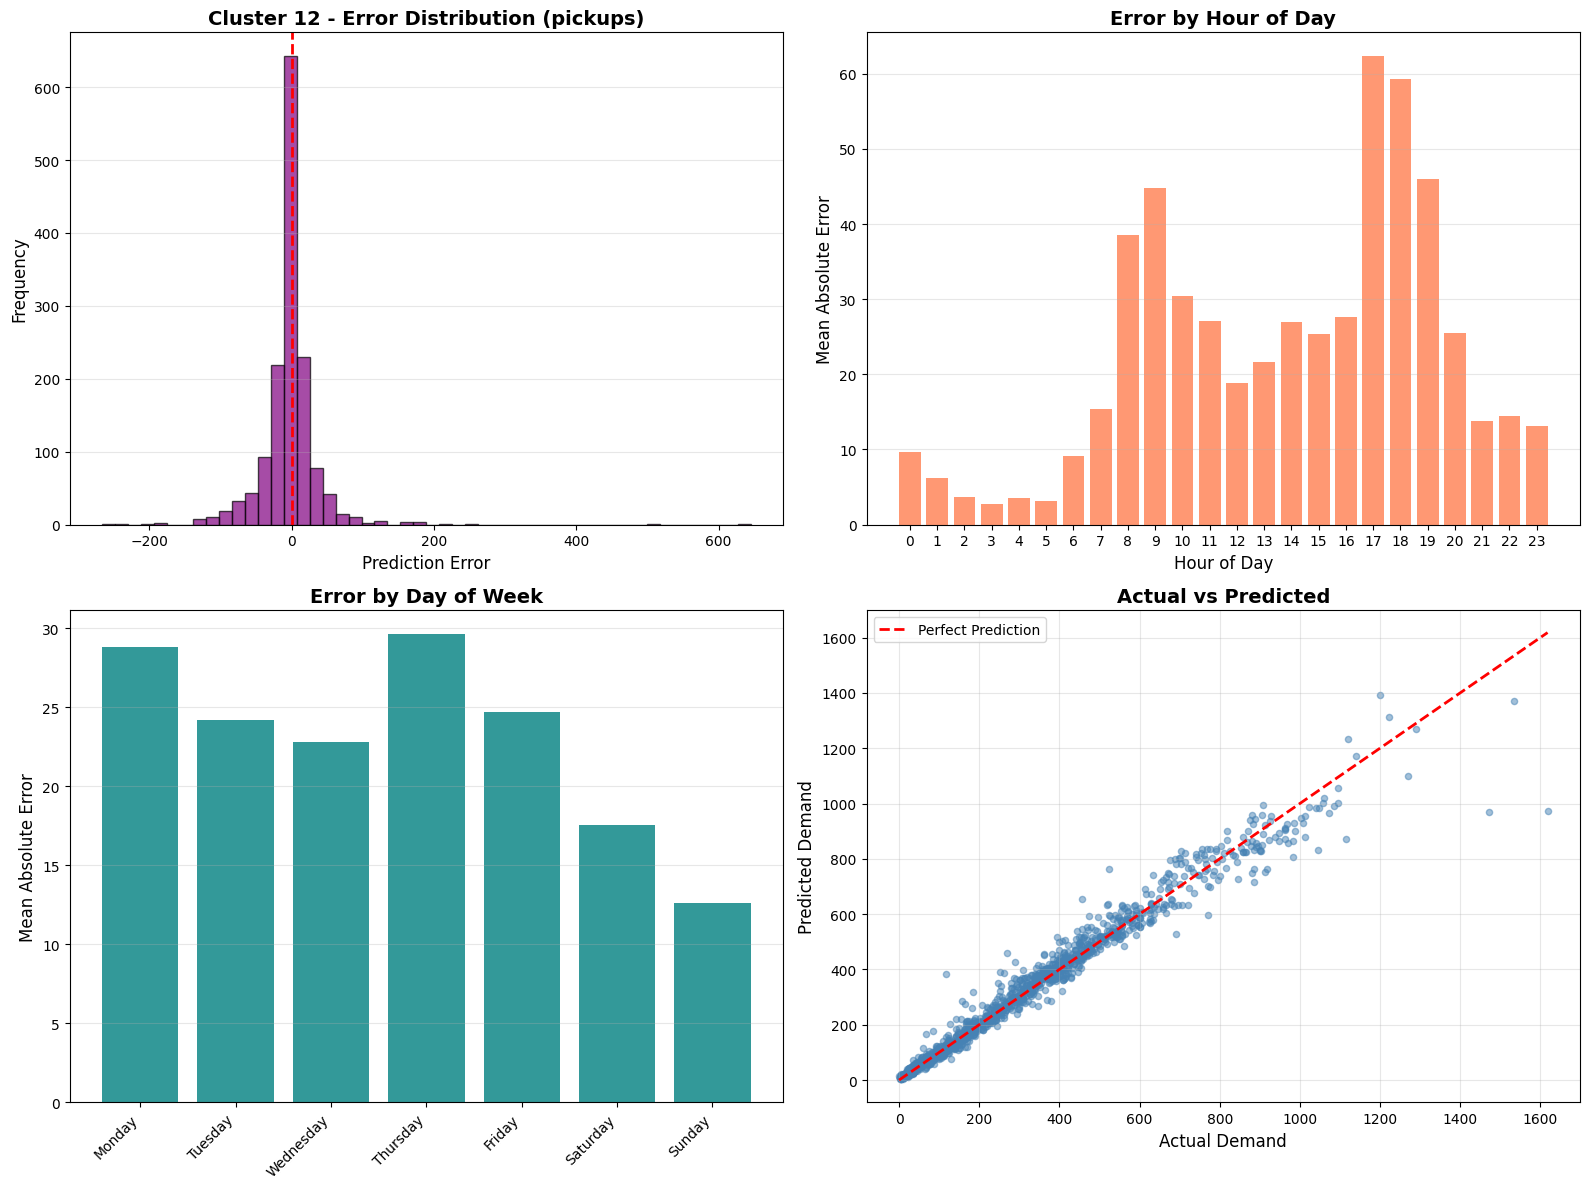


Error Statistics for Cluster 12 (pickups):
  Mean Absolute Error: 22.89
  Median Absolute Error: 11.68
  Mean Percentage Error: 14.55%
  Std Dev of Error: 42.79

--- Cluster 12 - Dropoffs ---


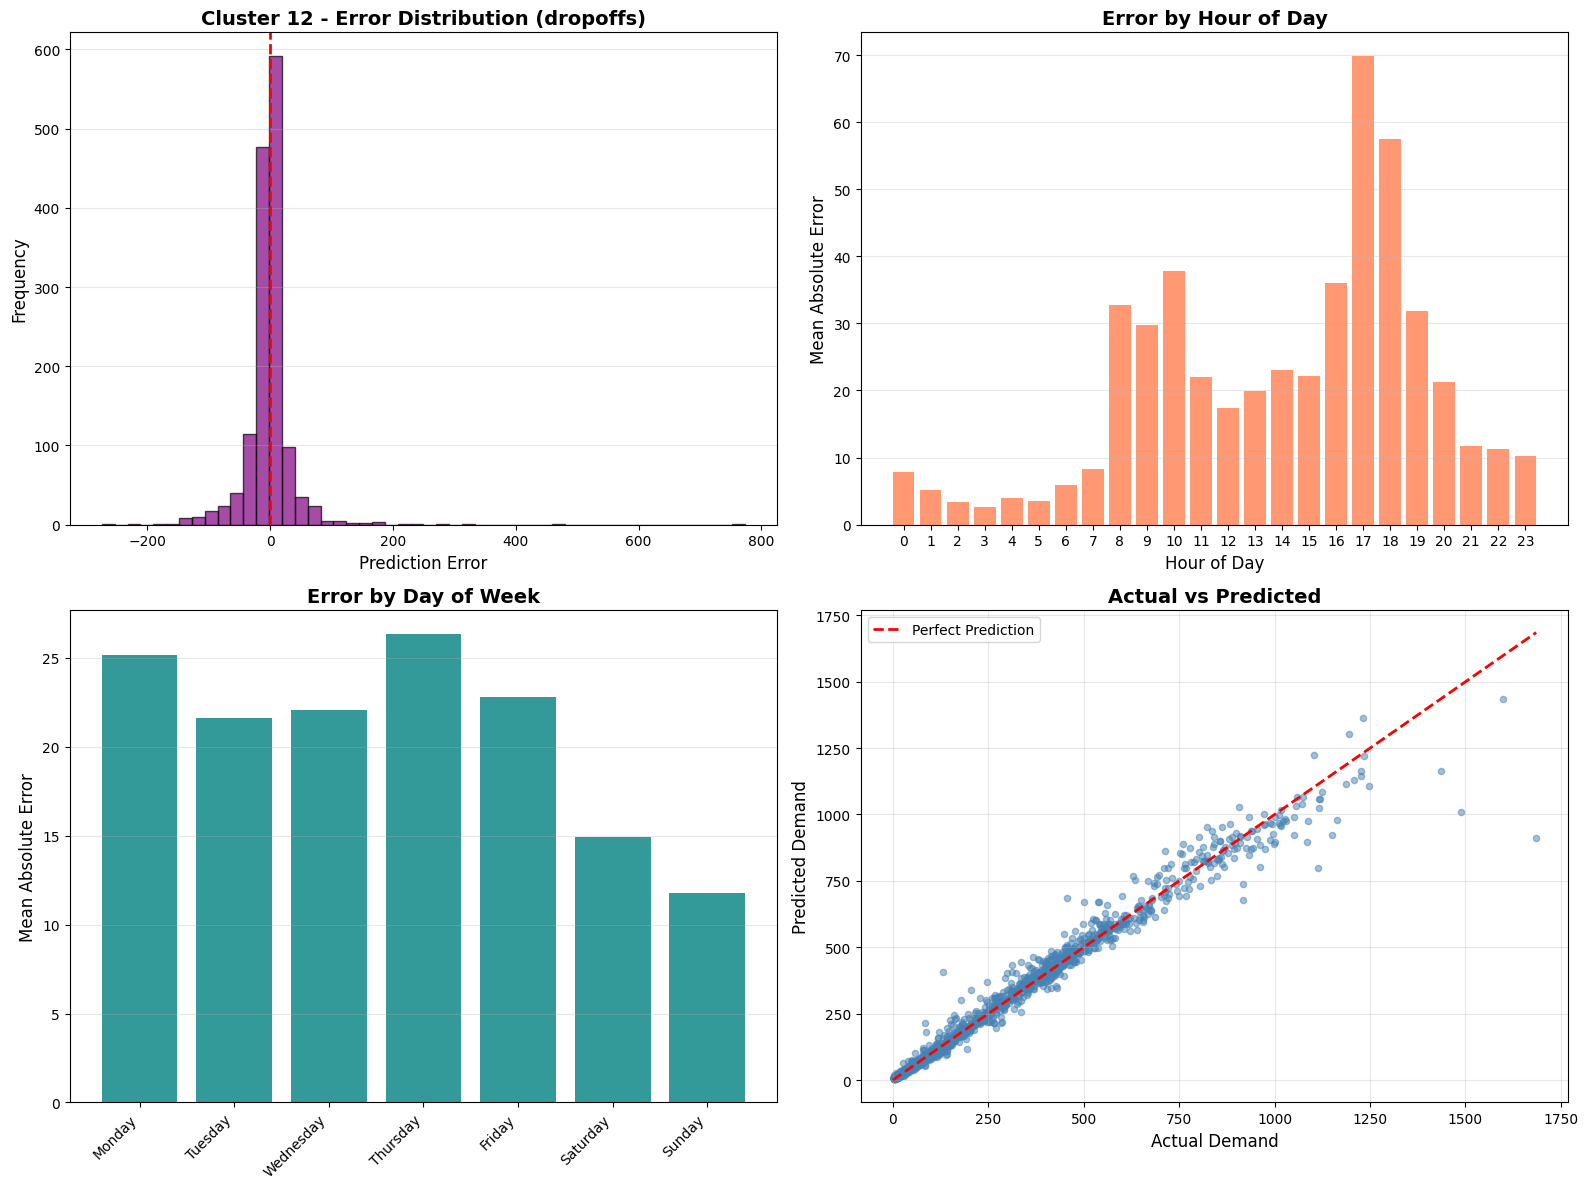


Error Statistics for Cluster 12 (dropoffs):
  Mean Absolute Error: 20.64
  Median Absolute Error: 9.11
  Mean Percentage Error: 13.85%
  Std Dev of Error: 43.13

--- Cluster 1 - Pickups ---


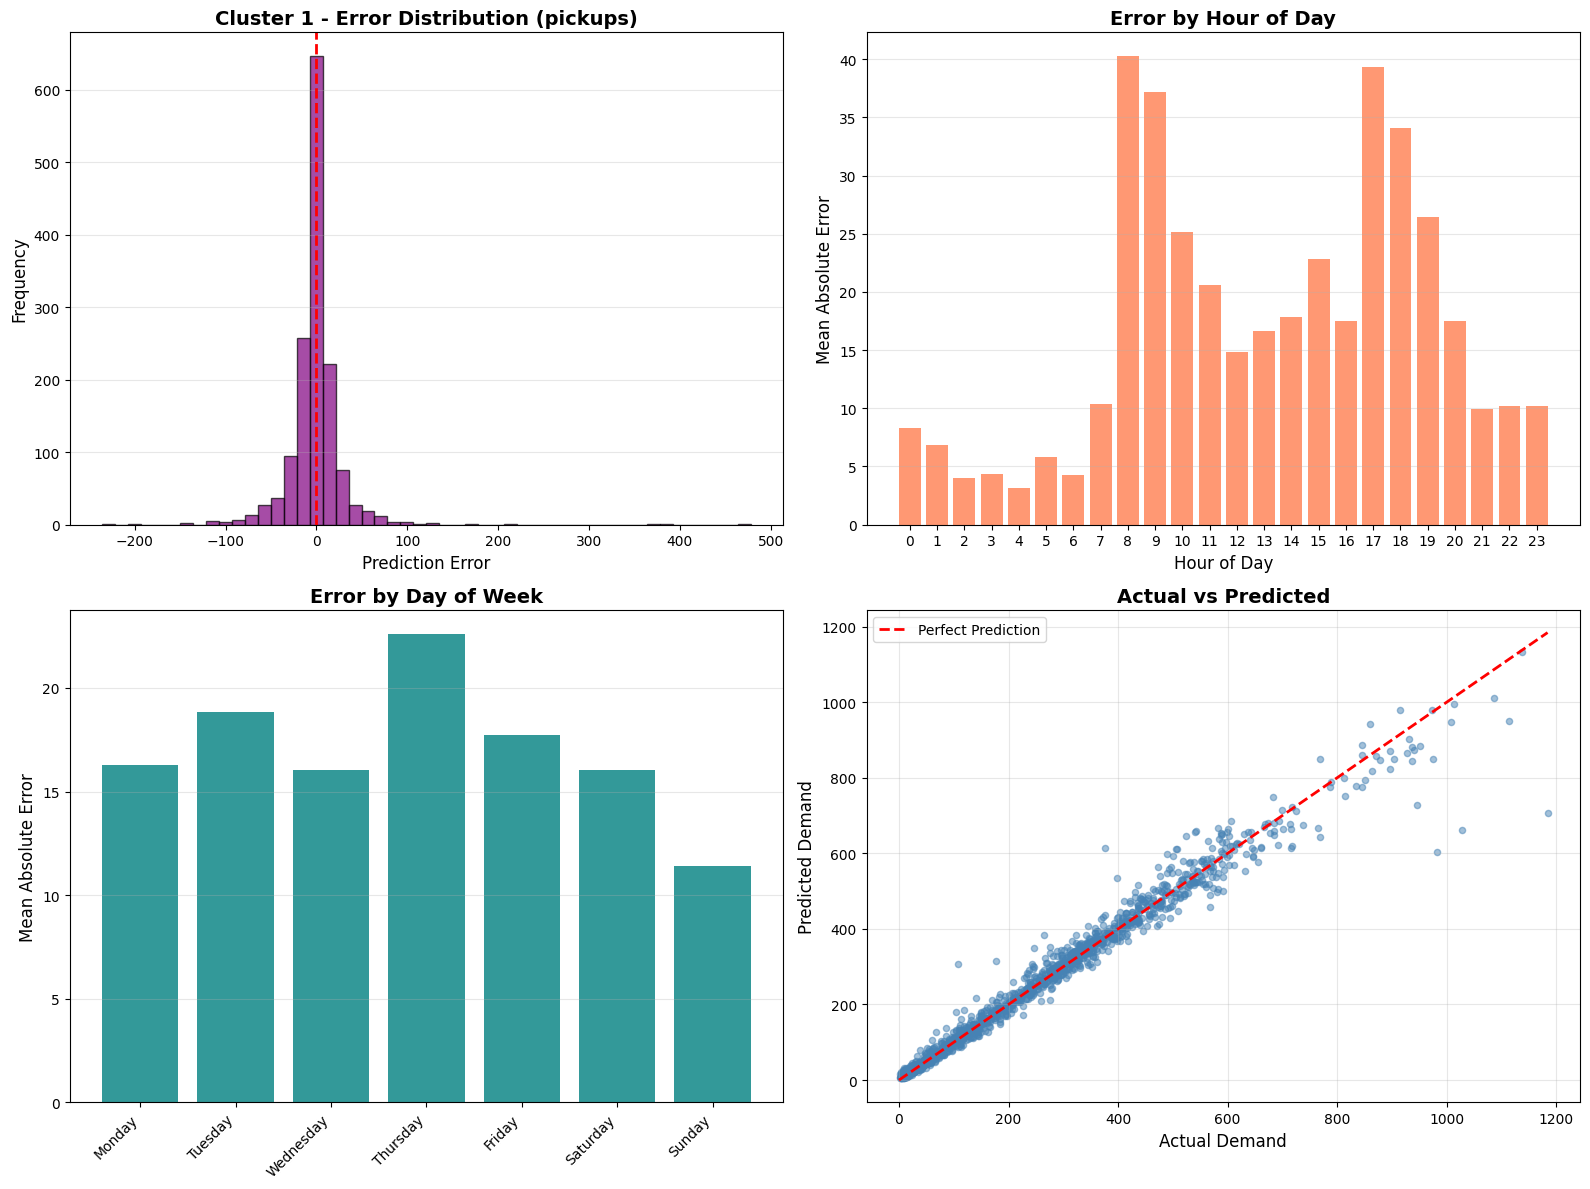


Error Statistics for Cluster 1 (pickups):
  Mean Absolute Error: 16.98
  Median Absolute Error: 9.01
  Mean Percentage Error: 13.74%
  Std Dev of Error: 32.84

--- Cluster 1 - Dropoffs ---


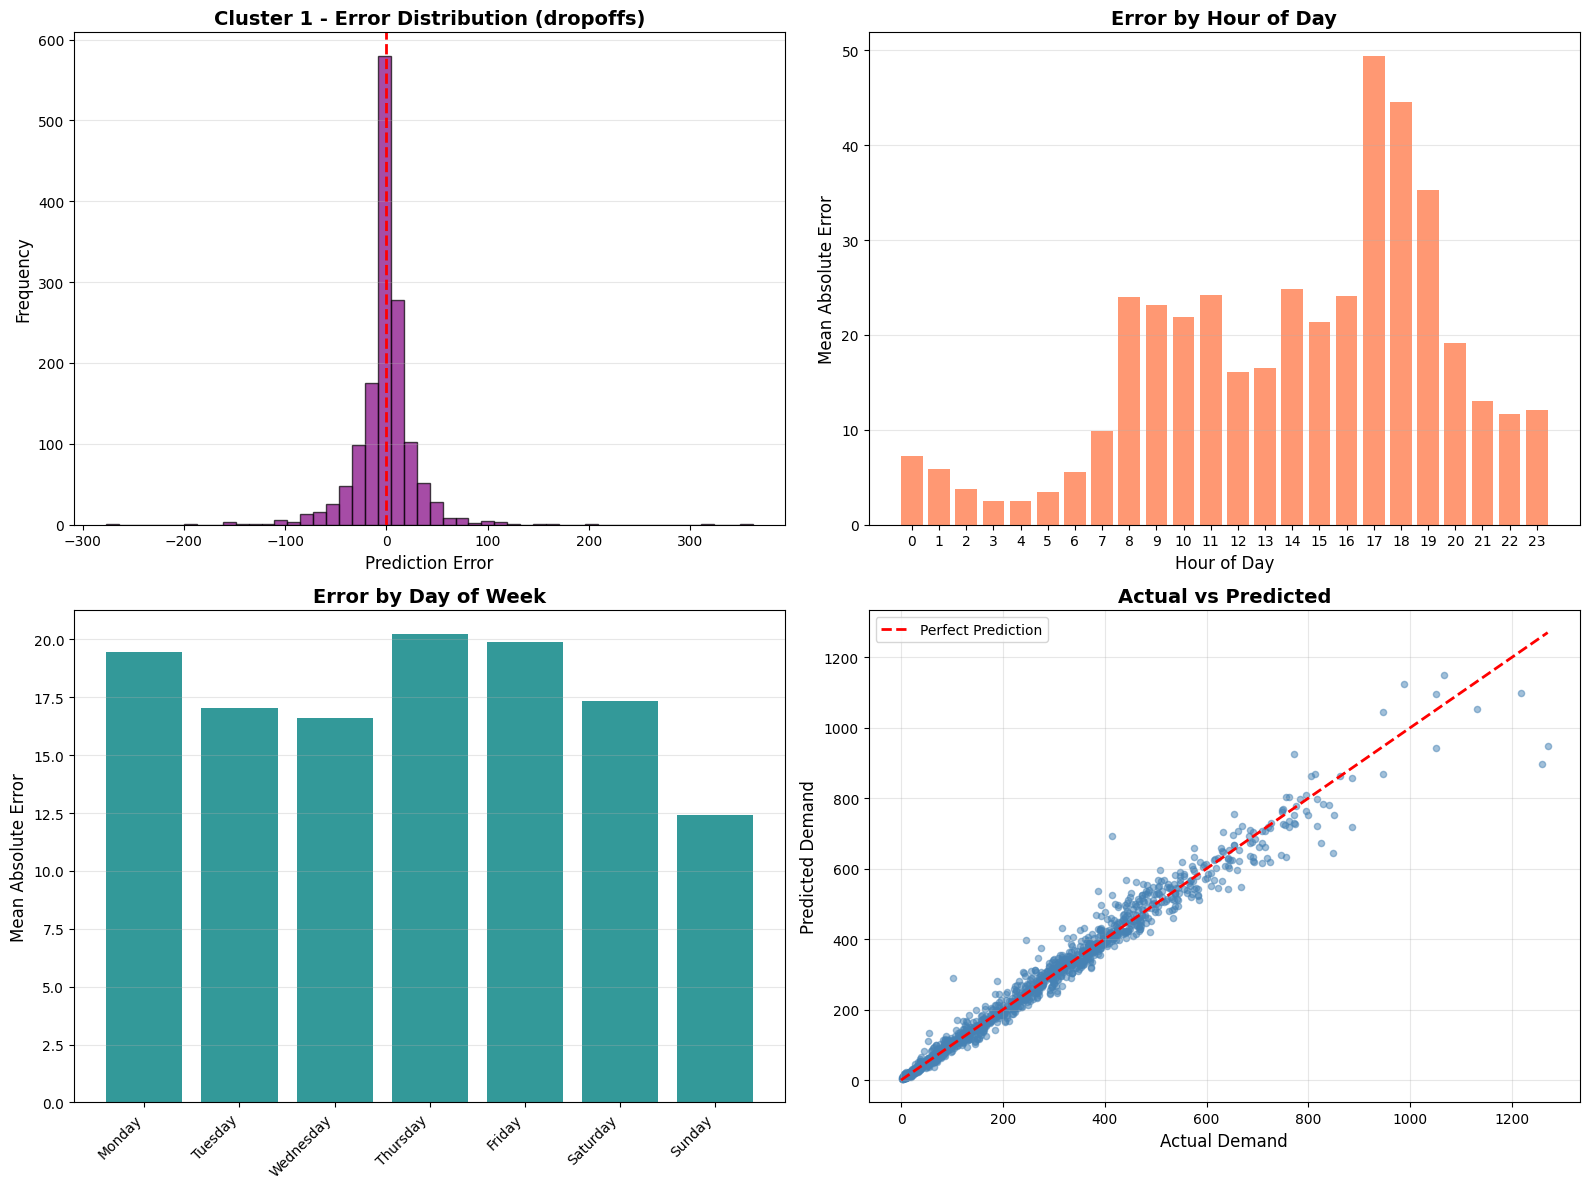


Error Statistics for Cluster 1 (dropoffs):
  Mean Absolute Error: 17.59
  Median Absolute Error: 8.88
  Mean Percentage Error: 11.94%
  Std Dev of Error: 31.52

--- Cluster 4 - Pickups ---


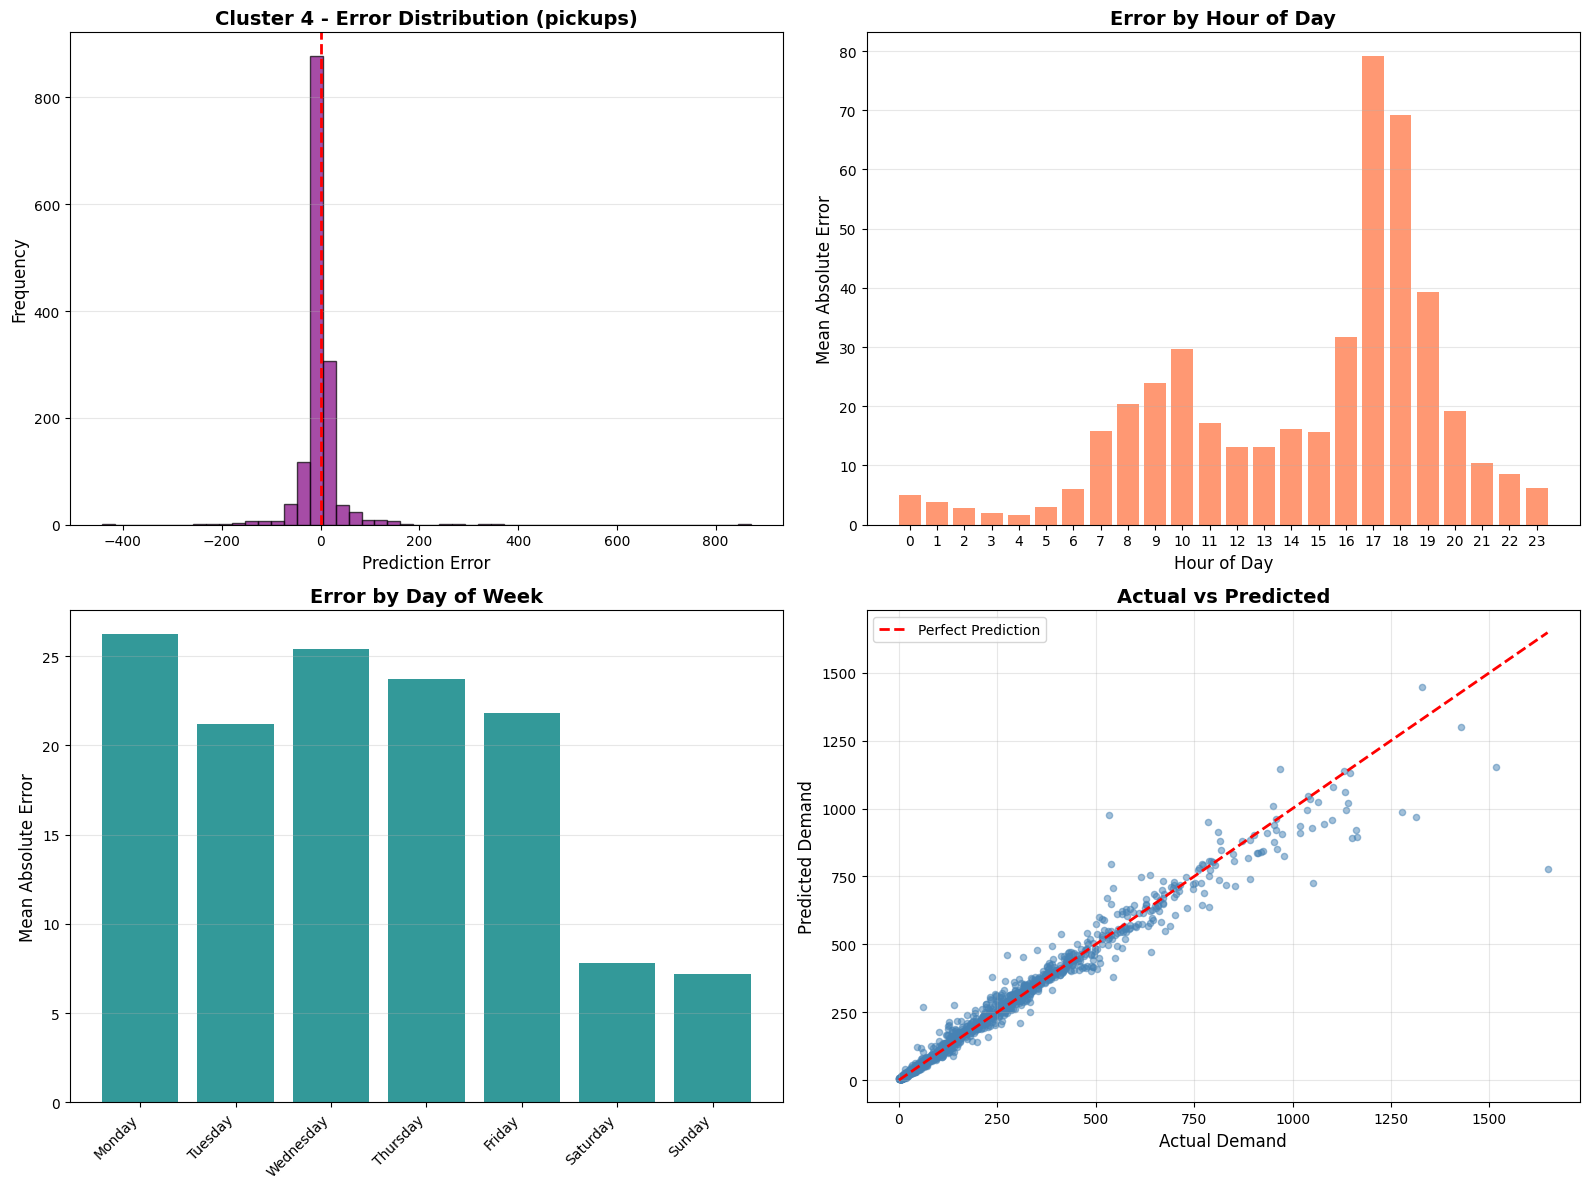


Error Statistics for Cluster 4 (pickups):
  Mean Absolute Error: 18.91
  Median Absolute Error: 7.31
  Mean Percentage Error: 14.07%
  Std Dev of Error: 45.56

--- Cluster 4 - Dropoffs ---


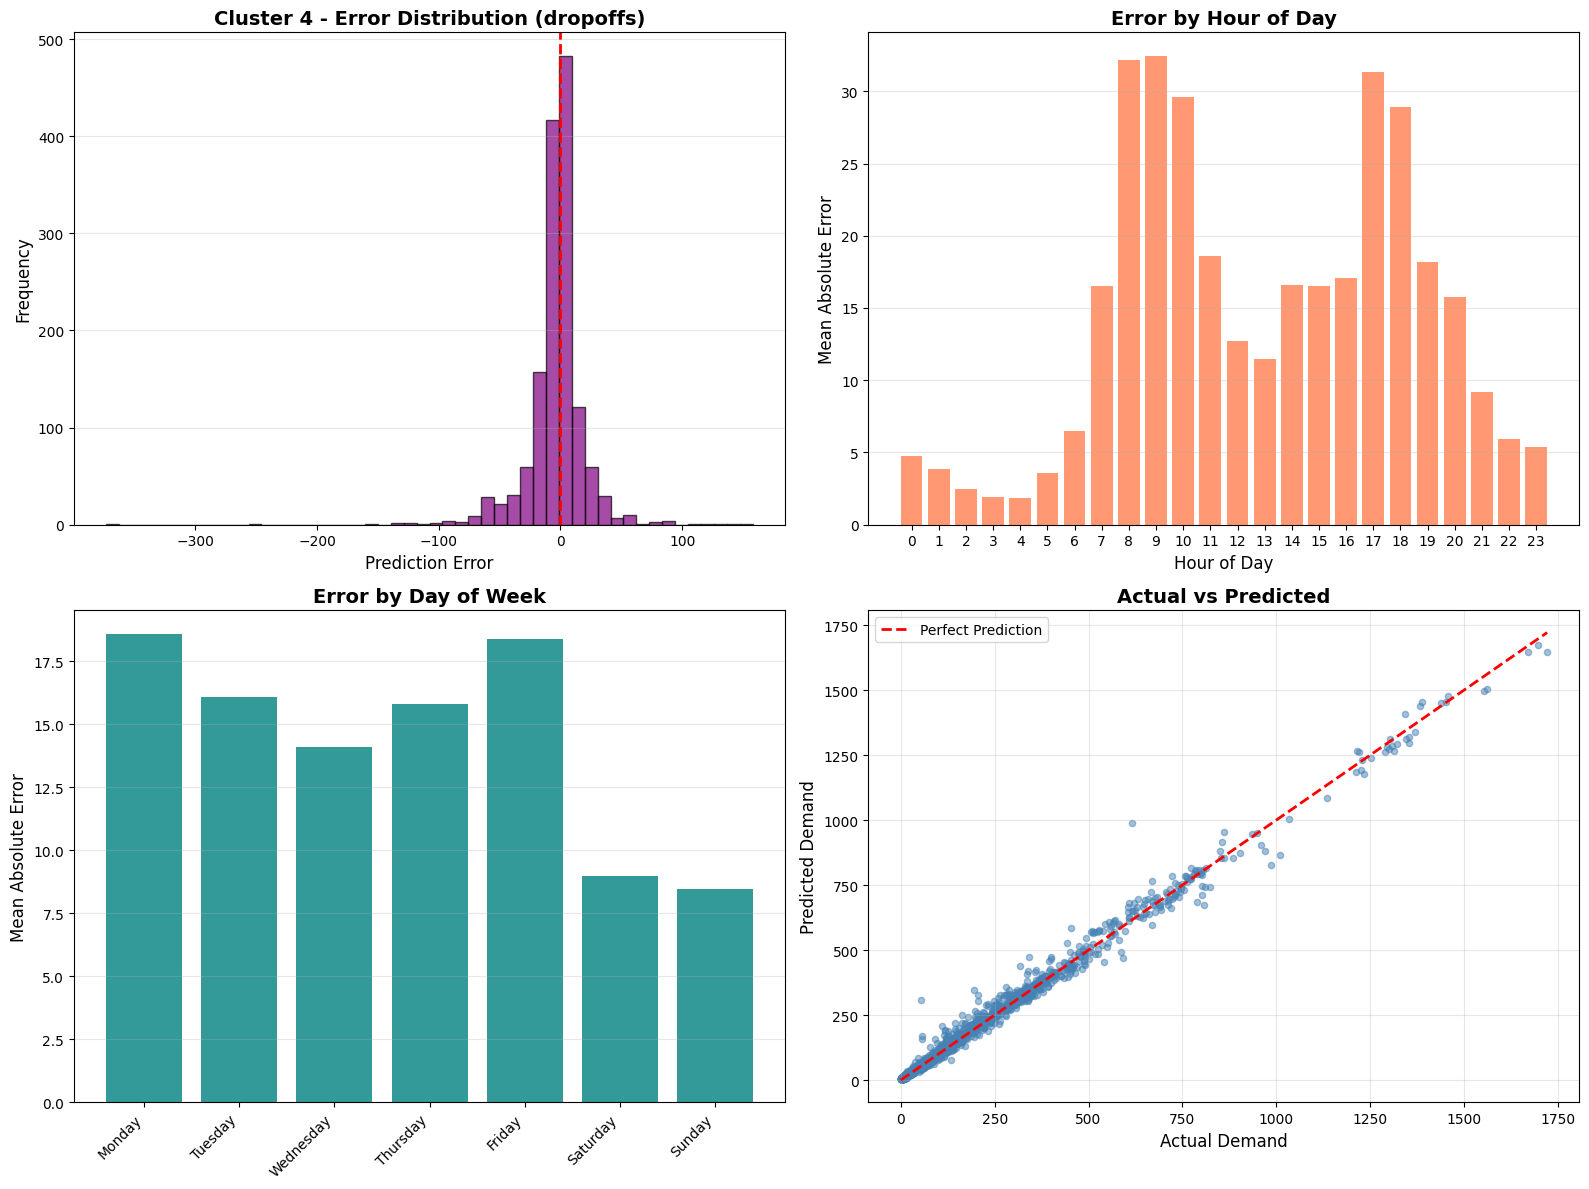


Error Statistics for Cluster 4 (dropoffs):
  Mean Absolute Error: 14.33
  Median Absolute Error: 7.18
  Mean Percentage Error: 14.81%
  Std Dev of Error: 26.14


In [17]:
def analyze_prediction_errors(predictions_data, cluster_id, demand_type='pickups'):
    """
    Analyze when and where the model makes errors
    """
    predictions_data = predictions_data.copy()
    predictions_data['error'] = predictions_data['actual'] - predictions_data['predicted']
    predictions_data['abs_error'] = np.abs(predictions_data['error'])
    predictions_data['pct_error'] = (predictions_data['abs_error'] / (predictions_data['actual'] + 1)) * 100
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Error distribution
    axes[0, 0].hist(predictions_data['error'], bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Prediction Error', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title(f'Cluster {cluster_id} - Error Distribution ({demand_type})', 
                        fontweight='bold', fontsize=14)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Error by hour of day
    error_by_hour = predictions_data.groupby('hour')['abs_error'].mean()
    axes[0, 1].bar(error_by_hour.index, error_by_hour.values, color='coral', alpha=0.8)
    axes[0, 1].set_xlabel('Hour of Day', fontsize=12)
    axes[0, 1].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[0, 1].set_title('Error by Hour of Day', fontweight='bold', fontsize=14)
    axes[0, 1].set_xticks(range(0, 24))
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Error by day of week
    predictions_data['day_of_week_name'] = pd.to_datetime(predictions_data['date']).dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    error_by_day = predictions_data.groupby('day_of_week_name')['abs_error'].mean().reindex(day_order)
    axes[1, 0].bar(range(len(error_by_day)), error_by_day.values, color='teal', alpha=0.8)
    axes[1, 0].set_xticks(range(len(day_order)))
    axes[1, 0].set_xticklabels(day_order, rotation=45, ha='right', fontsize=10)
    axes[1, 0].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[1, 0].set_title('Error by Day of Week', fontweight='bold', fontsize=14)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Actual vs Predicted scatter
    axes[1, 1].scatter(predictions_data['actual'], predictions_data['predicted'], 
                      alpha=0.5, s=20, color='steelblue')
    max_val = max(predictions_data['actual'].max(), predictions_data['predicted'].max())
    axes[1, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 1].set_xlabel('Actual Demand', fontsize=12)
    axes[1, 1].set_ylabel('Predicted Demand', fontsize=12)
    axes[1, 1].set_title('Actual vs Predicted', fontweight='bold', fontsize=14)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nError Statistics for Cluster {cluster_id} ({demand_type}):")
    print(f"  Mean Absolute Error: {predictions_data['abs_error'].mean():.2f}")
    print(f"  Median Absolute Error: {predictions_data['abs_error'].median():.2f}")
    print(f"  Mean Percentage Error: {predictions_data['pct_error'].mean():.2f}%")
    print(f"  Std Dev of Error: {predictions_data['error'].std():.2f}")

# Analyze errors for each cluster
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

for cluster_id in selected_clusters:
    print(f"\n--- Cluster {cluster_id} - Pickups ---")
    analyze_prediction_errors(pickup_models[cluster_id]['predictions'], cluster_id, 'pickups')
    
    print(f"\n--- Cluster {cluster_id} - Dropoffs ---")
    analyze_prediction_errors(dropoff_models[cluster_id]['predictions'], cluster_id, 'dropoffs')